# Housekeeping:

In [2]:
options(repr.plot.width=14,repr.plot.antialias='subpixel',repr.plot.res=218)
sessionInfo()
update.packages()

R version 4.0.3 Patched (2020-10-12 r79333)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_4.0.3  ellipsis_0.3.1  IRdisplay_0.7.0 pbdZMQ_0.3-3   
 [5] tools_4.0.3     htmltools_0.5.0 pillar_1.4.6    base64enc_0.1-3
 [9] crayon_1.3.4    uuid_0.1-4      IRkernel_1.1.1  jsonlite_1.7.1 
[13] digest_0.6.25   lifecycle_0.2.0 repr_1.1.0      rlang_0.4.8    
[17] evaluate_0.14  

# More NBC

Load up on the necessary libraries. (Note that `randomForest` is the OG, but `ranger` is faster.)

In [3]:
#install.packages(c("tree","randomForest","ranger"))
library(gamlr)
library(tree)
library(randomForest)

Loading required package: Matrix

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



Read in the NBC data (now show characteristics):

In [4]:
nbc <- read.csv("nbc_showdetails.csv")

Also look at the show demographics for predicting genre:

In [5]:
demos <- read.csv("nbc_demographics.csv", row.names=1)
genre <- factor(nbc$Genre)

We can ask `tree` for a fitted model; it will know to fit a classification tree only if `genre` is a factor. It is not by default (on modern versions of R). Make sure we declare it to be.

In [6]:
genretree <- tree(genre ~ ., data=demos, mincut=1)

Plot the tree as a dendogram (Fig 9.2)

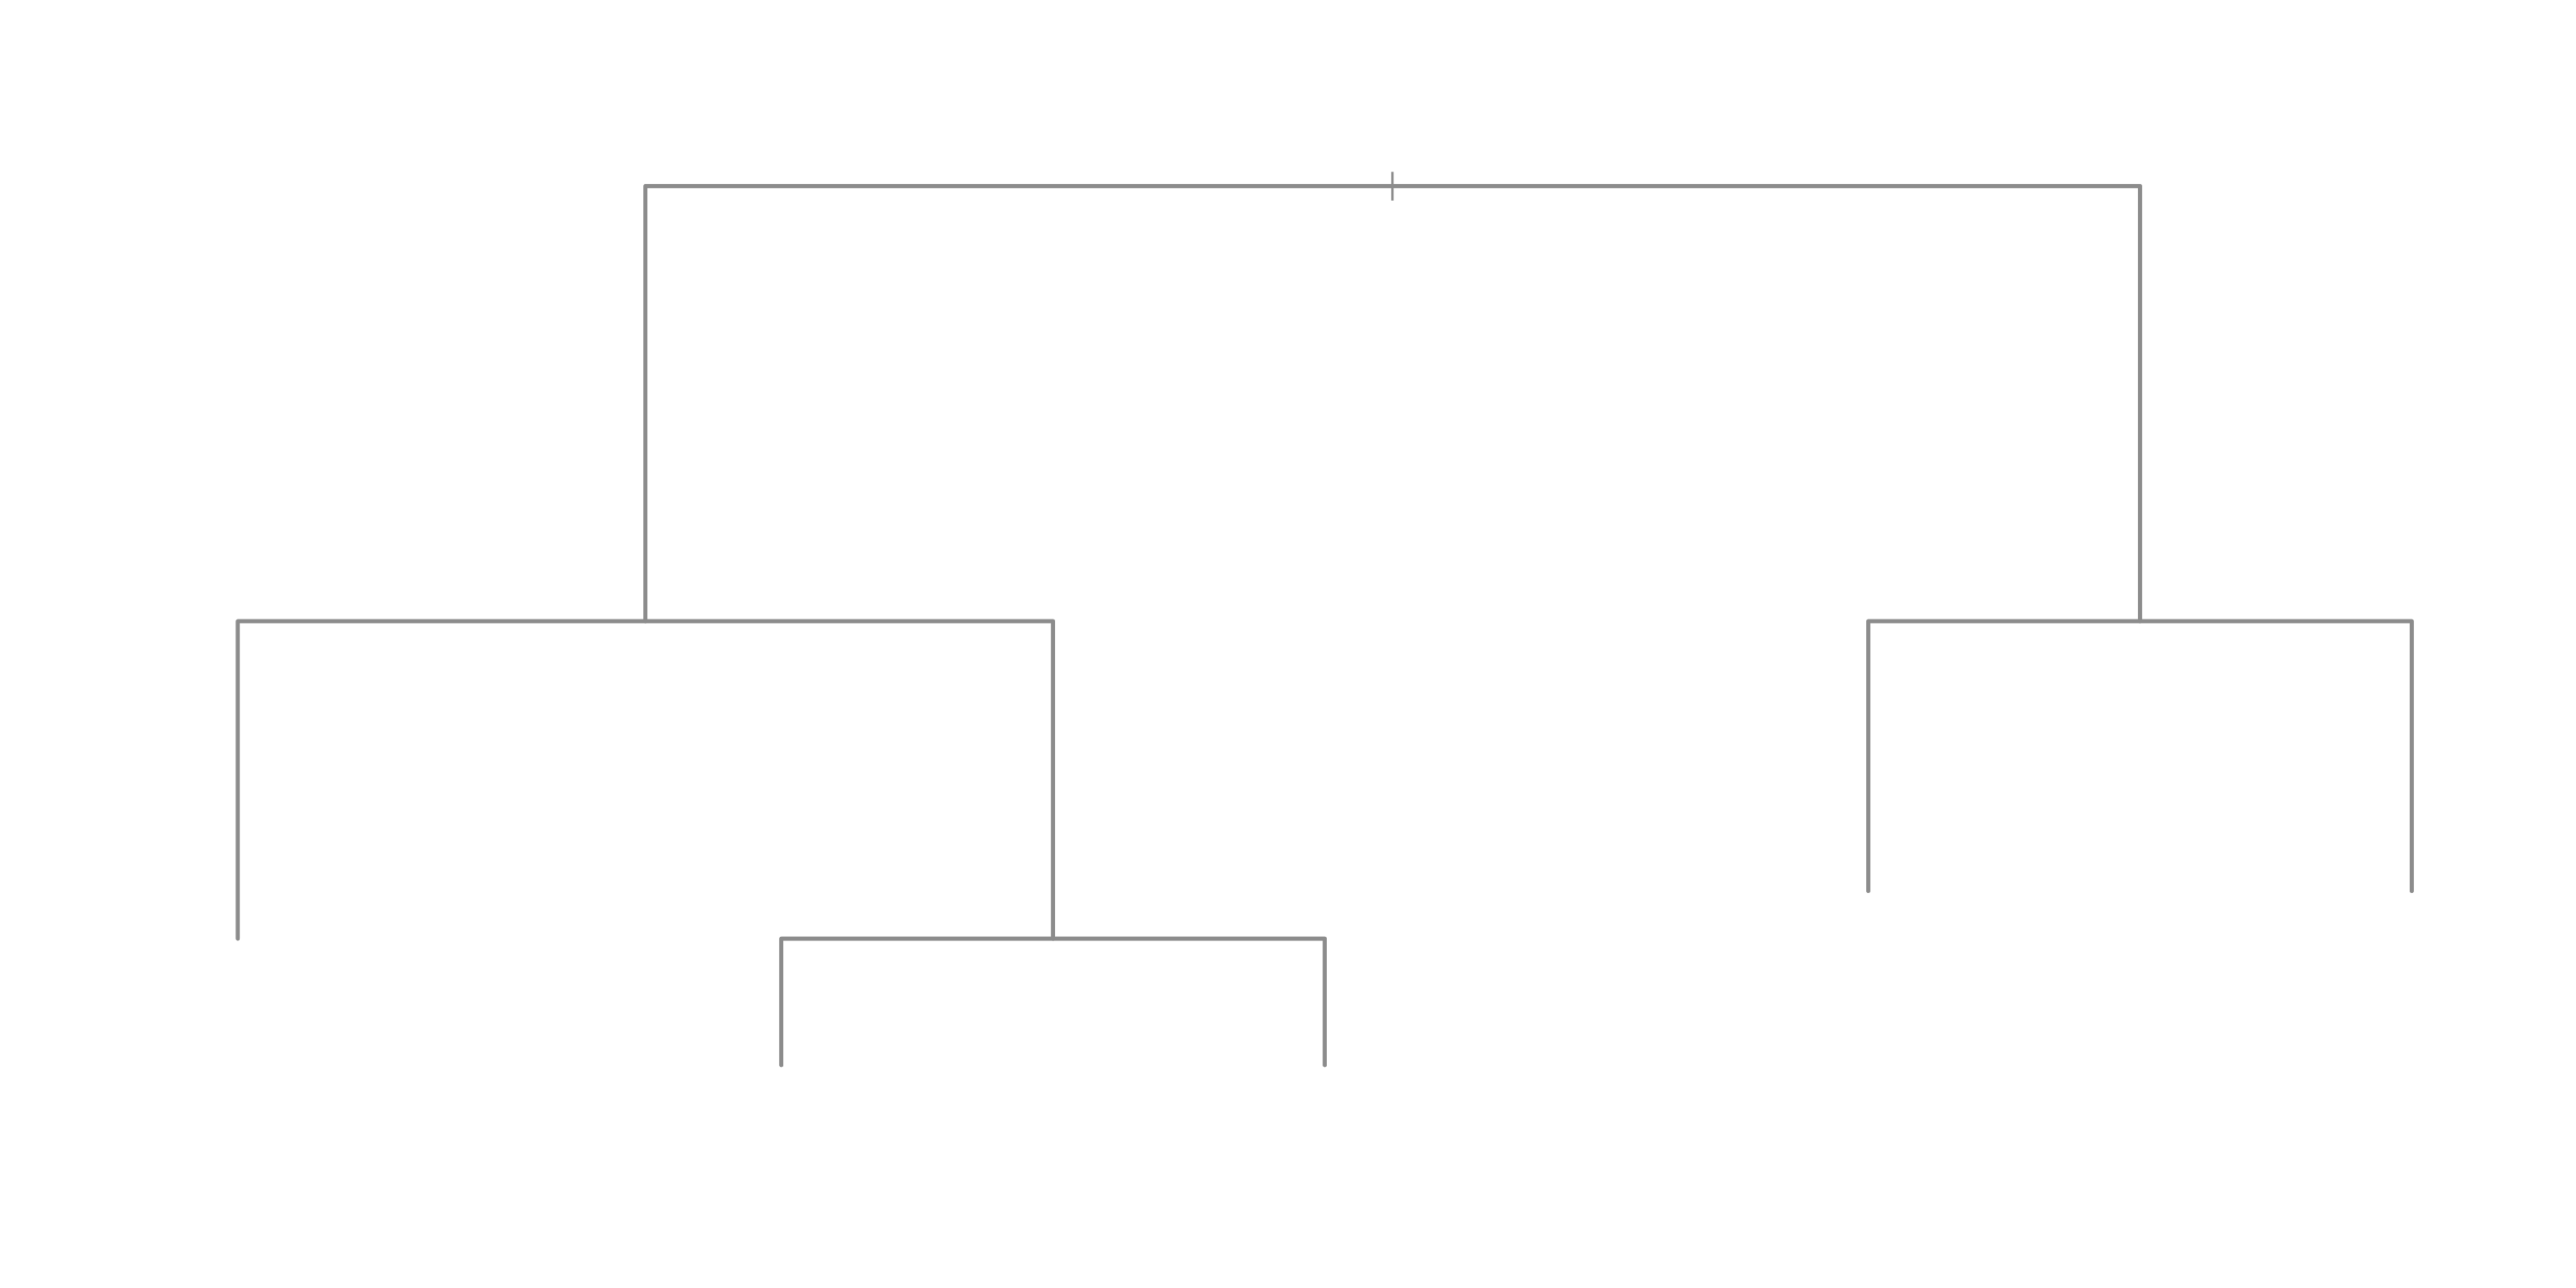

In [7]:
plot(genretree, col=8, lwd=2)

Actually, Fig 9.4 printed the predictive probabilities too:

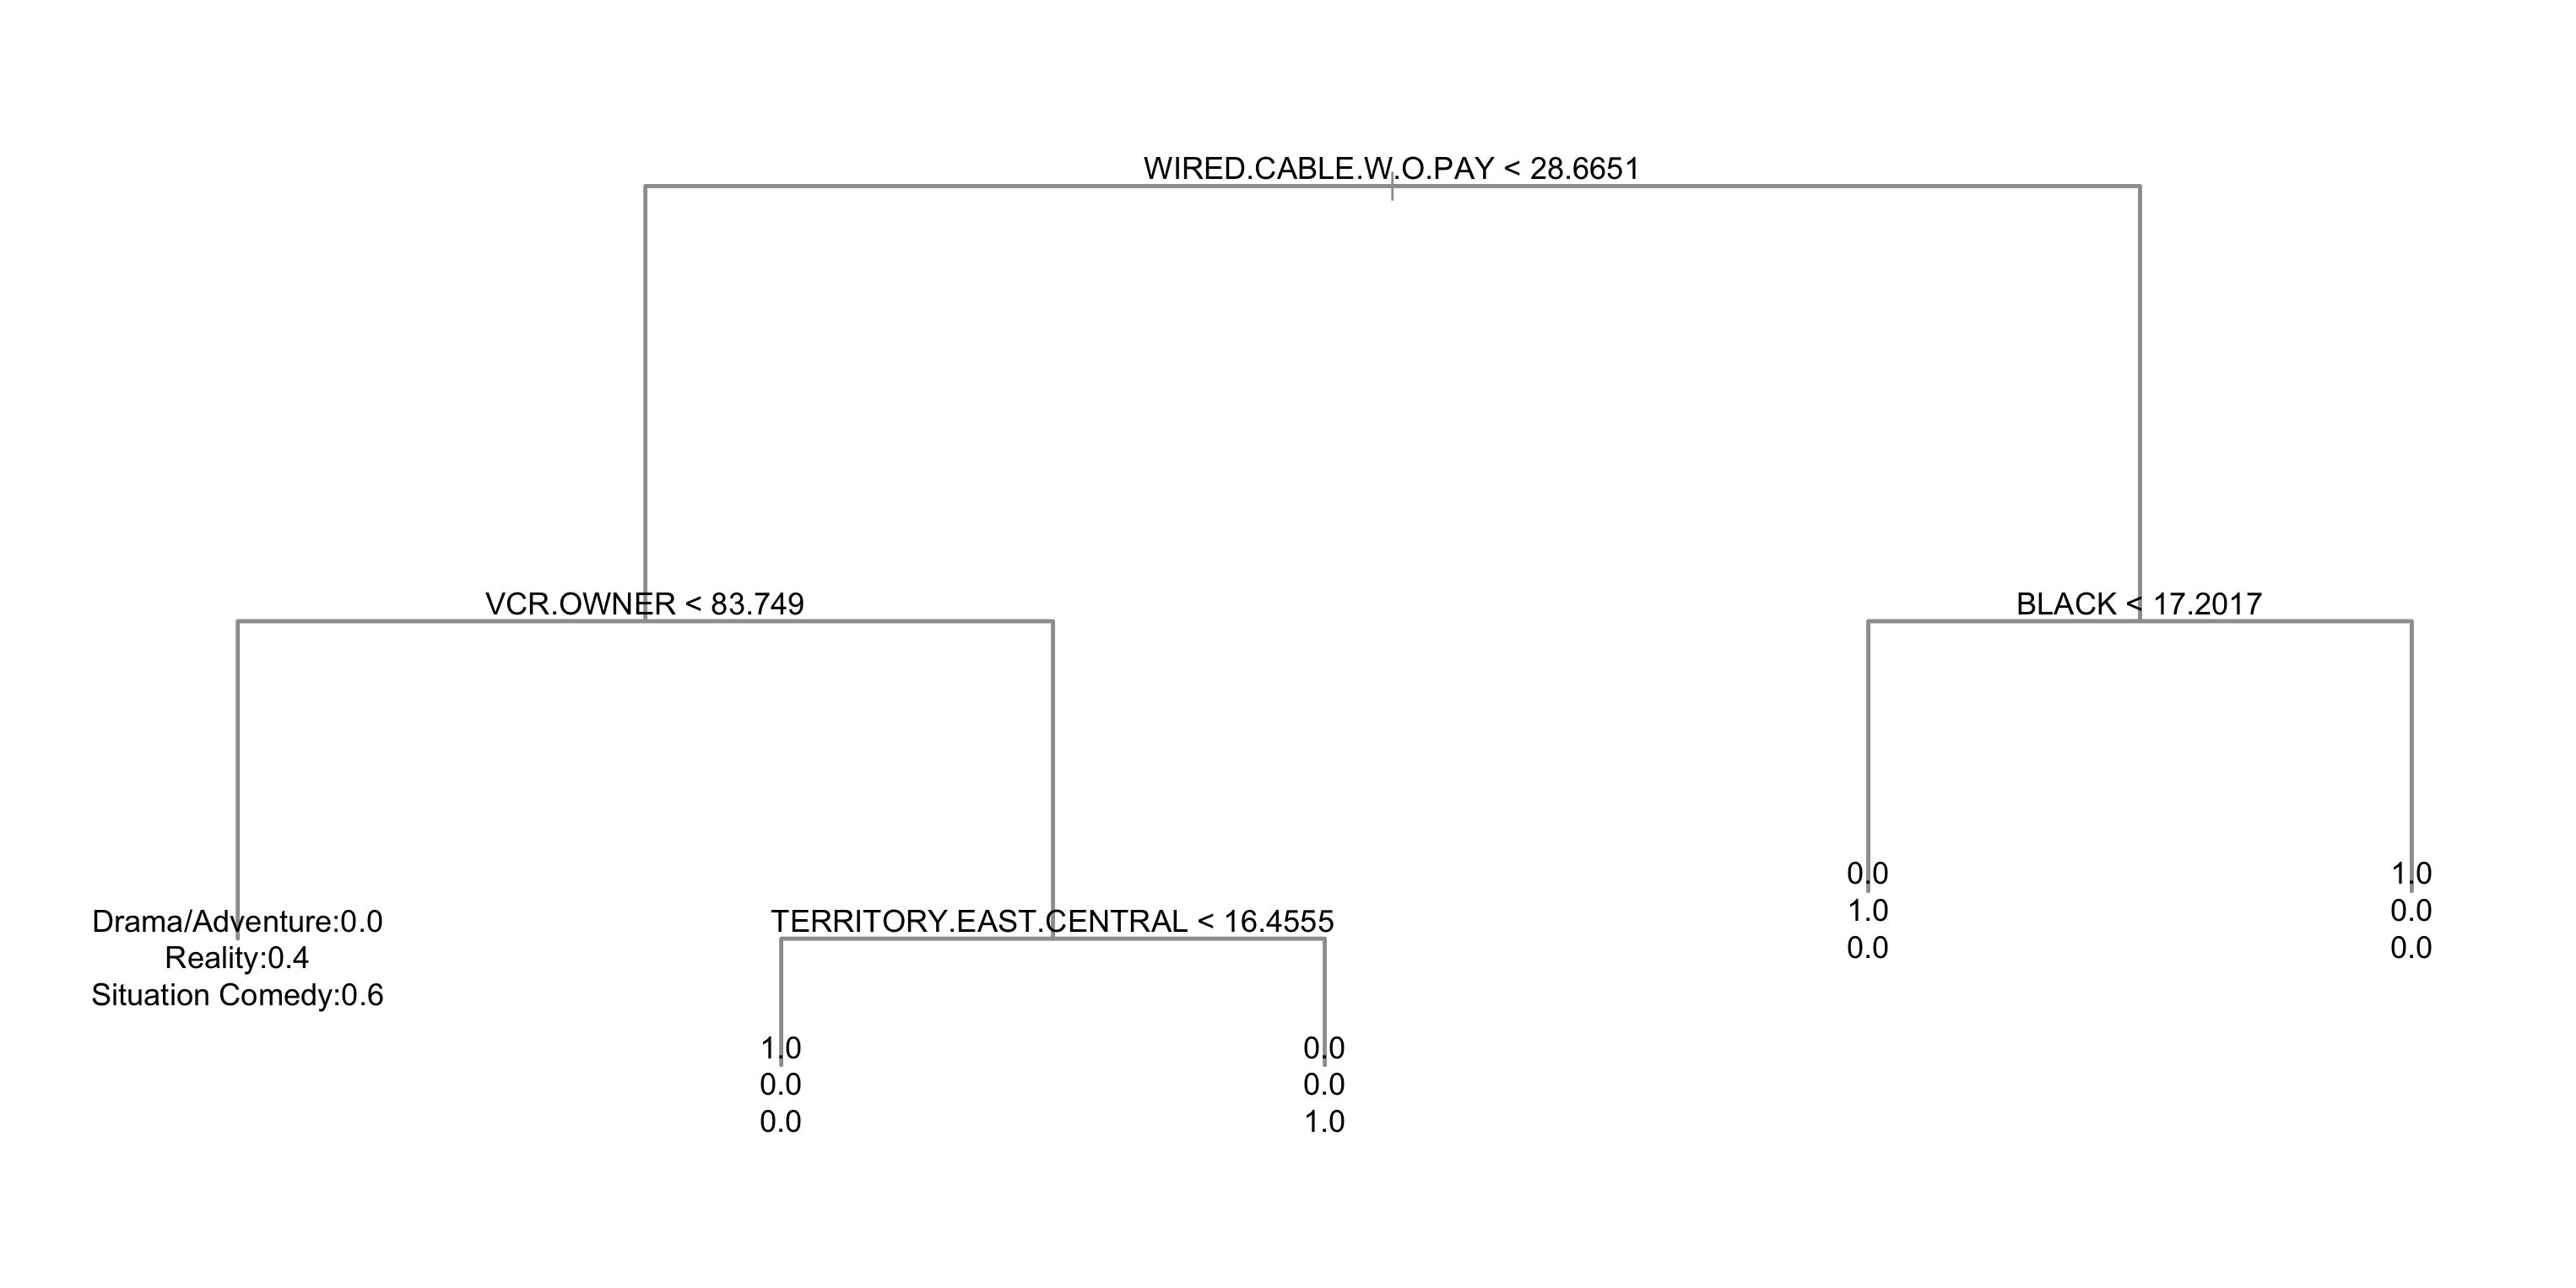

In [8]:
plot(genretree, col=8, lwd=2)
text(genretree, label="yprob")

We can also do prediction like with parametric models. (Use `type="class"`  to get maximal probability classifications.)

In [9]:
genrepred <- predict(genretree, newdata=demos, type="class")

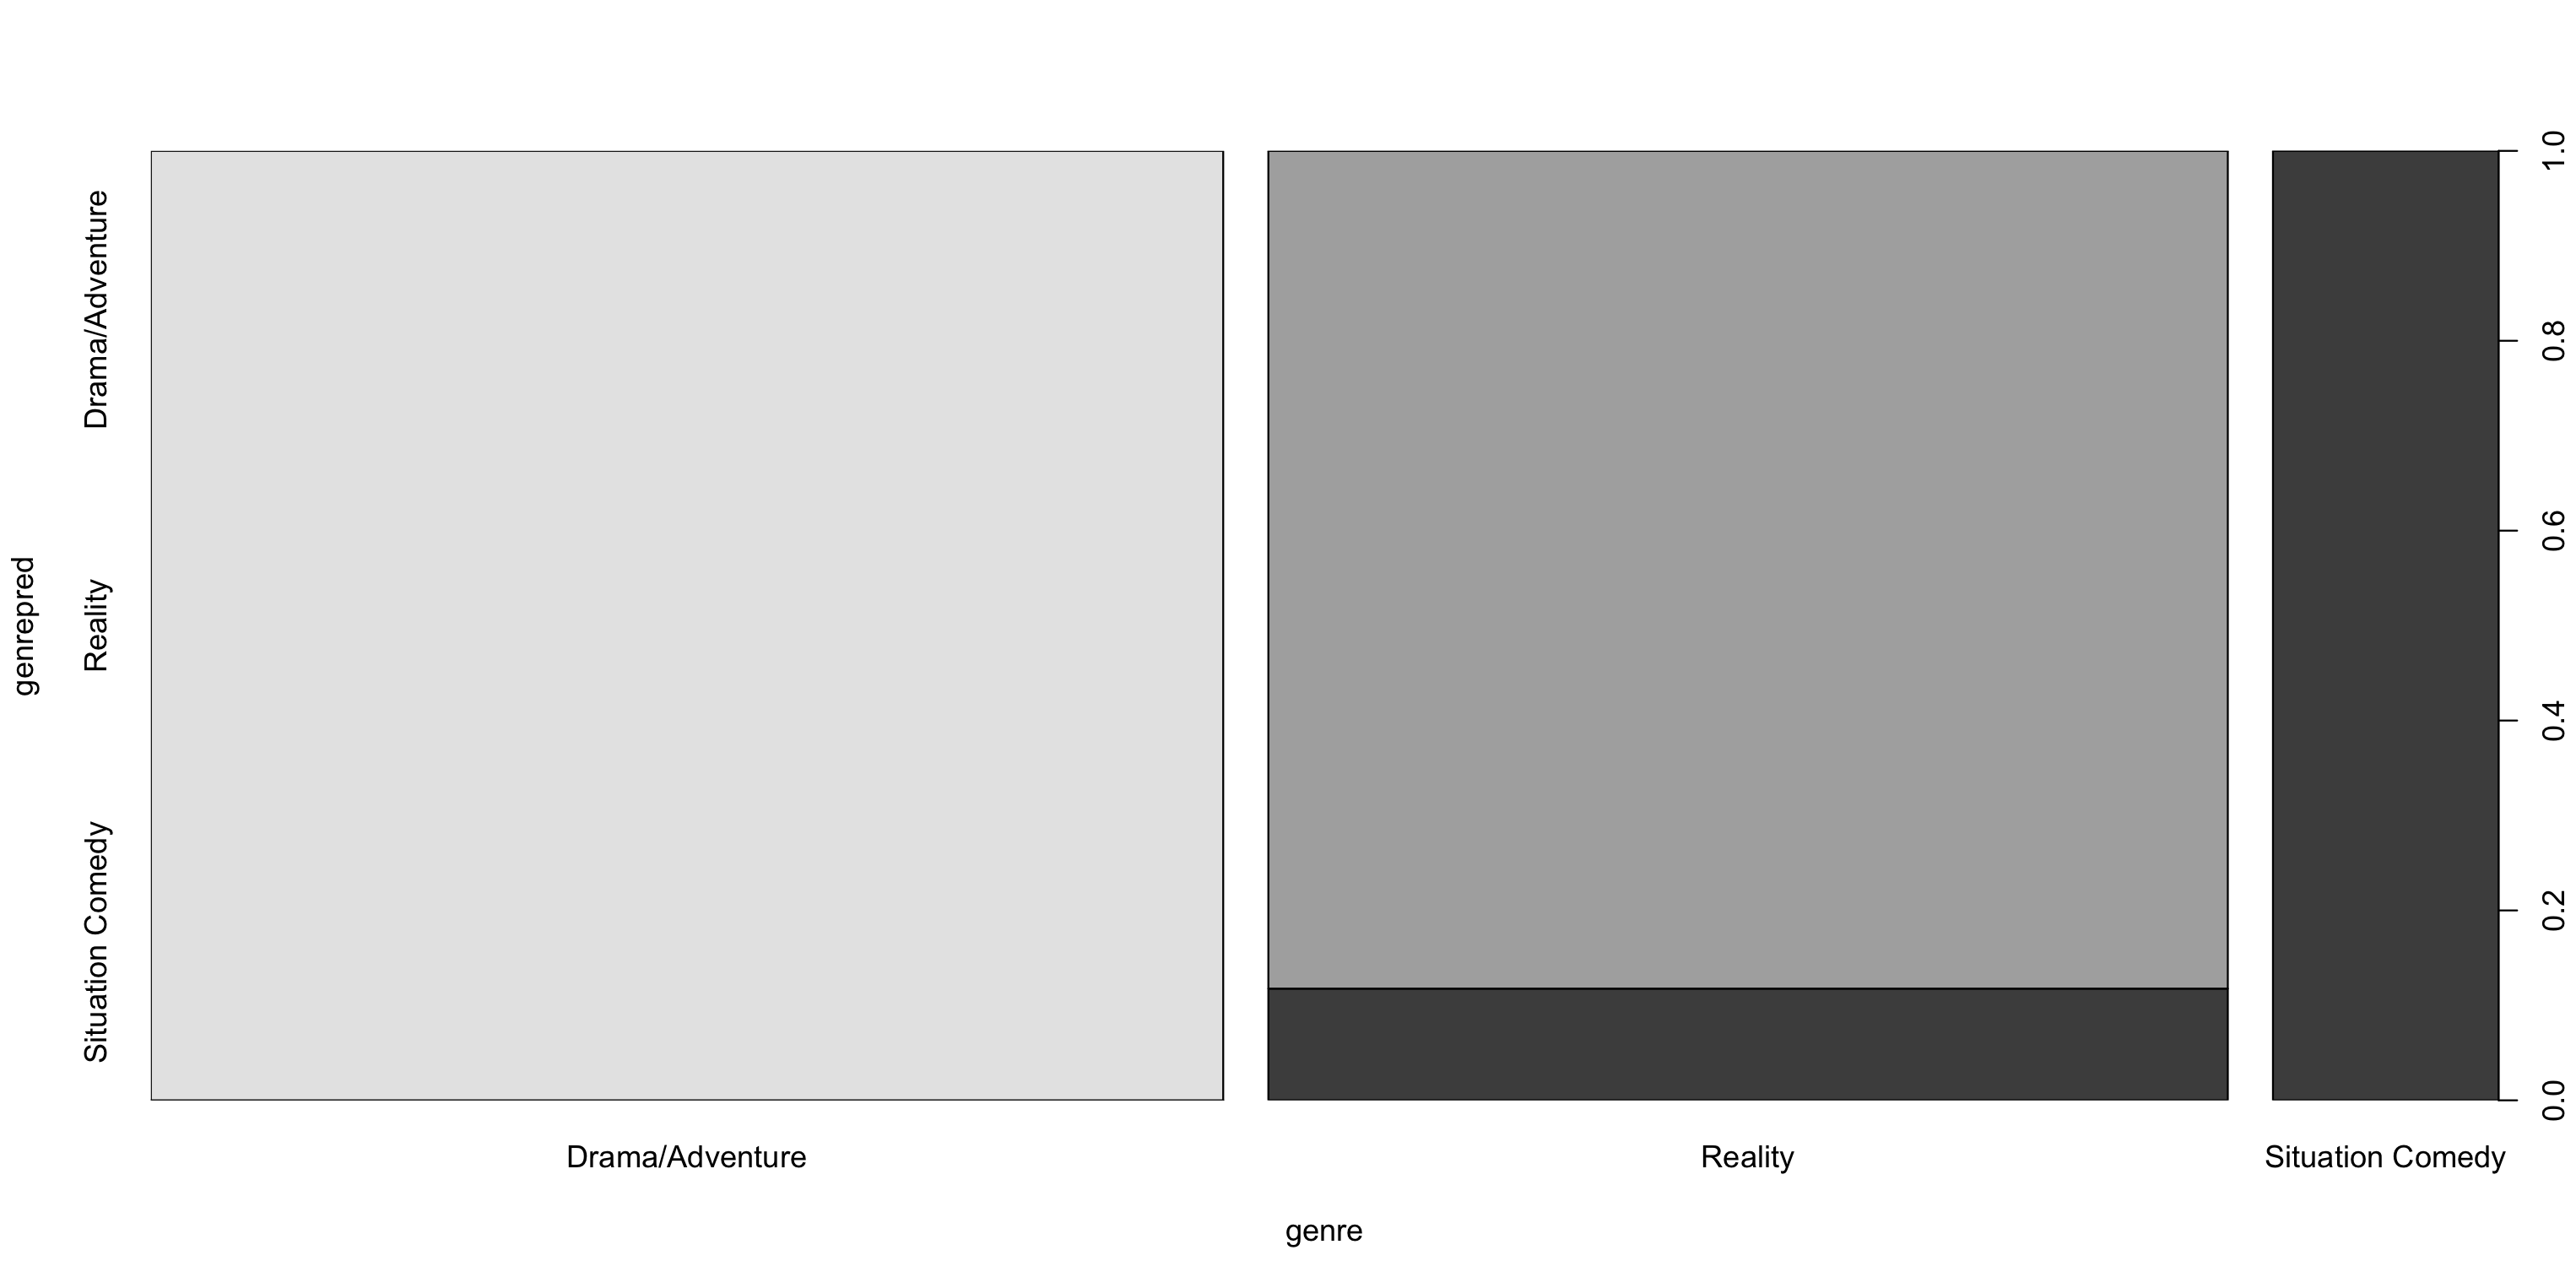

In [10]:
plot(genrepred ~ genre)

Jumping ahead for a random forest for classification:

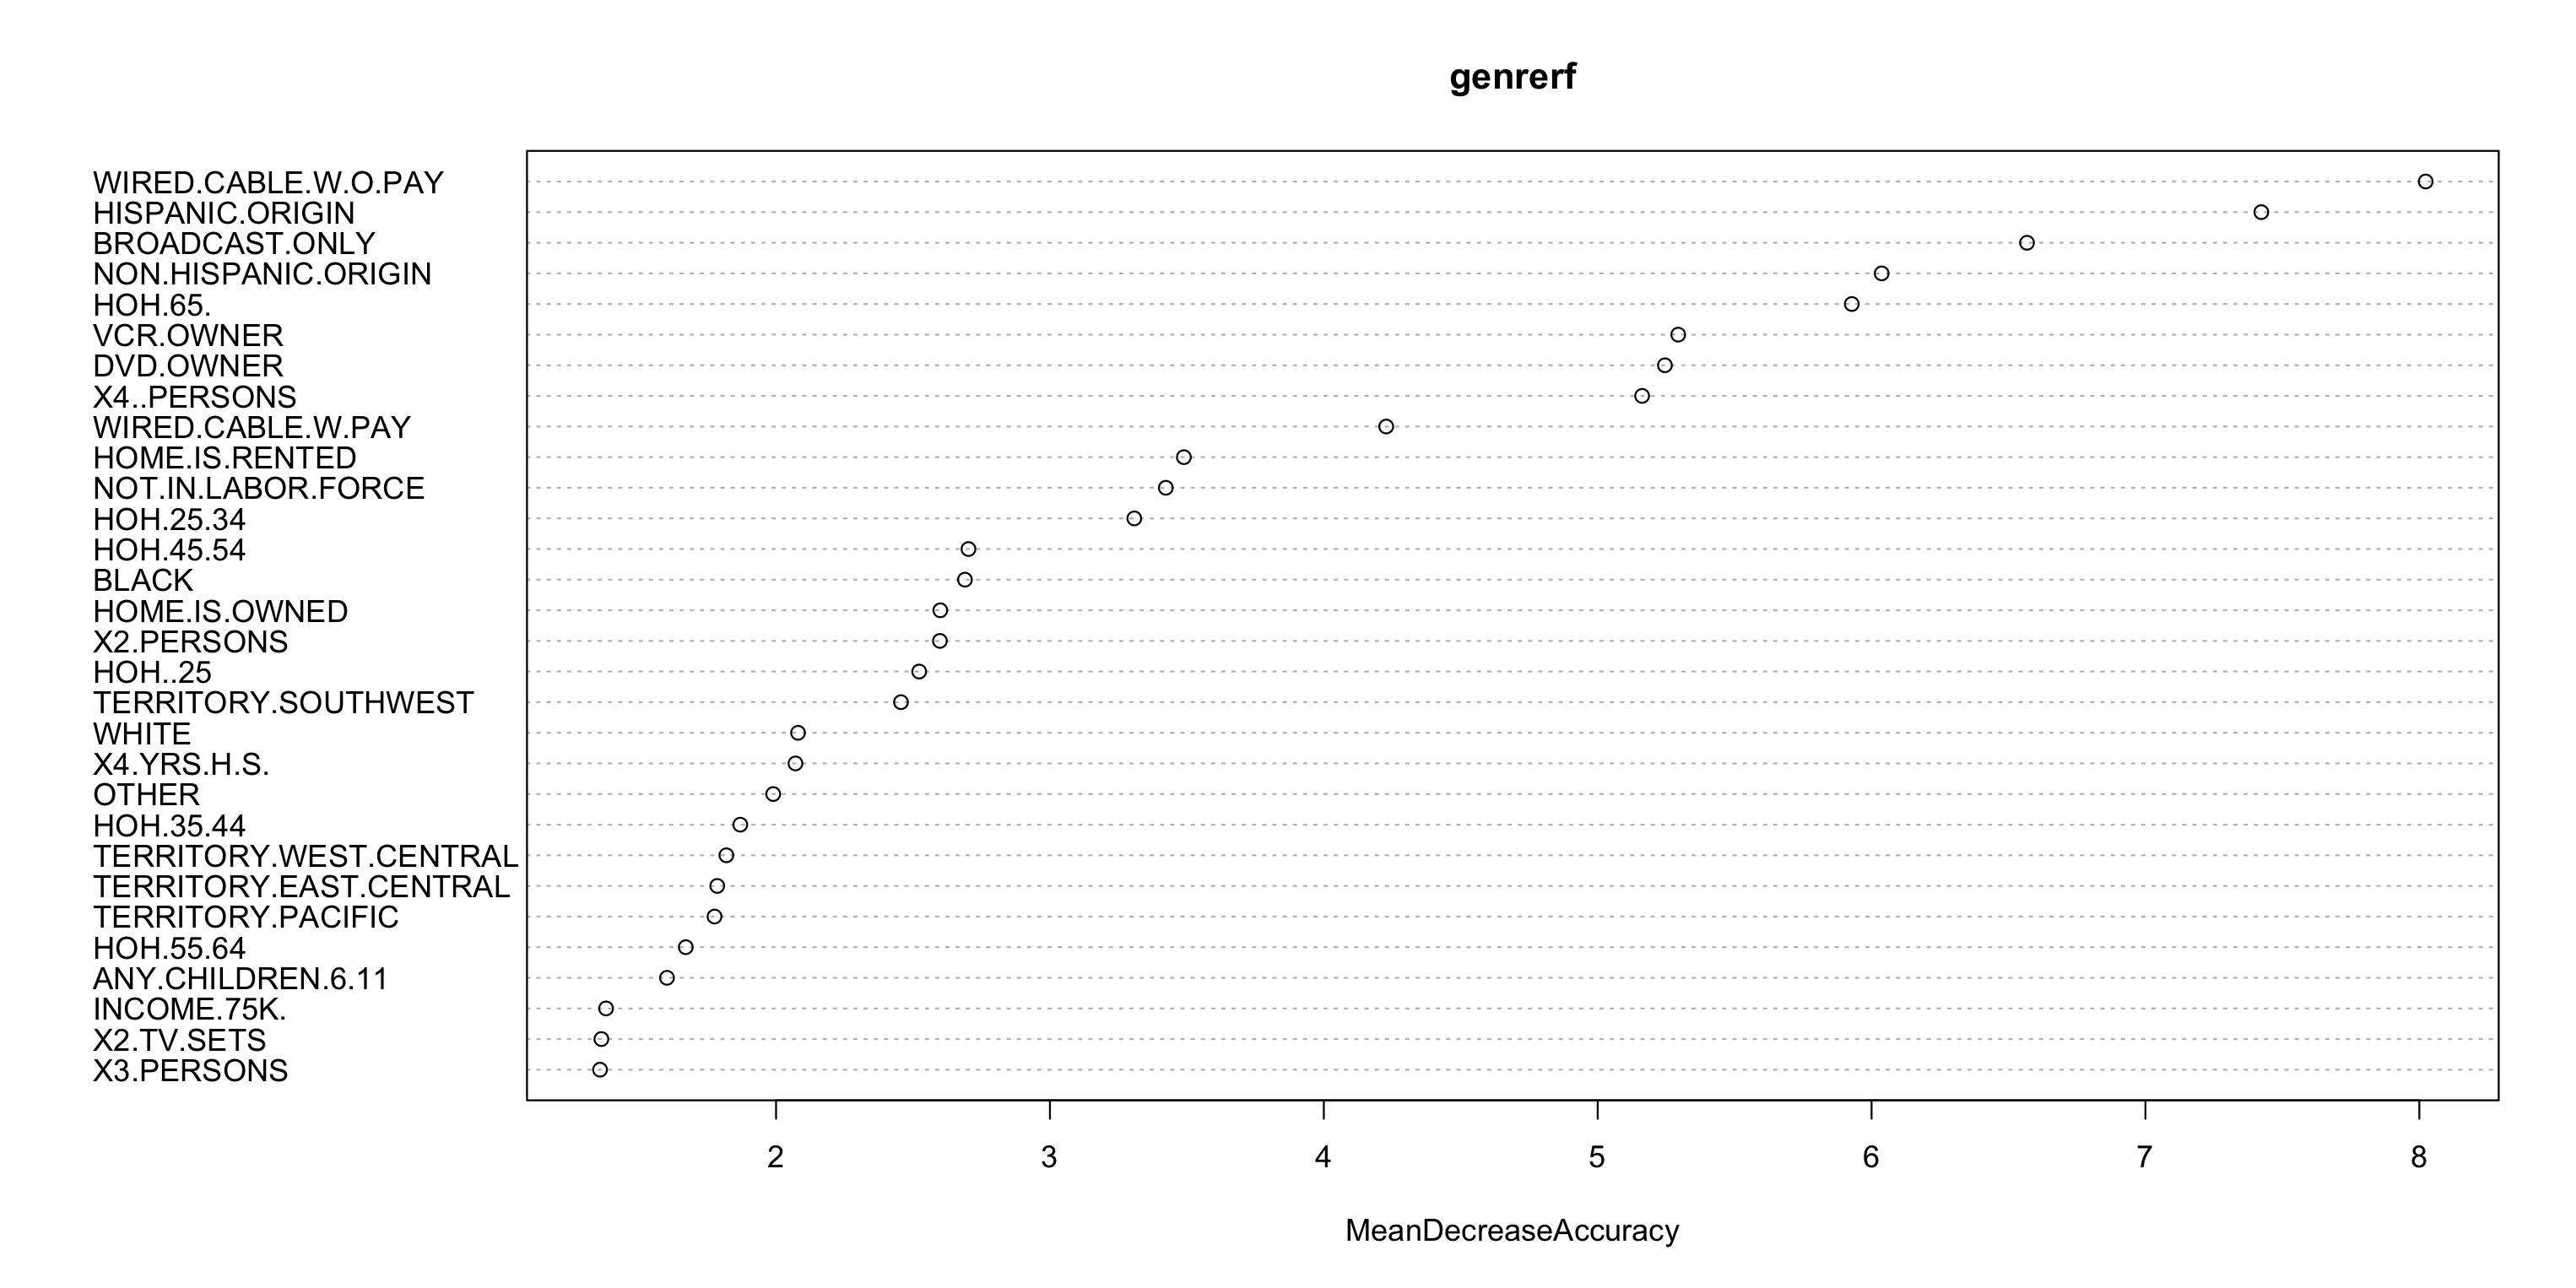

In [11]:
genrerf <- randomForest(genre ~ ., data=demos, importance=TRUE)
varImpPlot(genrerf,type=1)

RF also just gives you the maximal probality classification.

In [12]:
genrerfclass <- predict(genrerf, newdata=demos)

We can create a design matrix ourselves and re-name genre for convenience. This is *not* necessary because of turning to a continuous outcome (PE) now (confusingly distinguished as a 'regression tree'). It makes plotting easier afterward.

In [13]:
x <- as.data.frame(model.matrix(PE ~ Genre + GRP, data=nbc)[,-1])
names(x) <- c("reality","comedy","GRP")

Here's the new tree:

In [14]:
nbctree <- tree(nbc$PE ~ ., data=x, mincut=1)

We can plot the dendogram again:

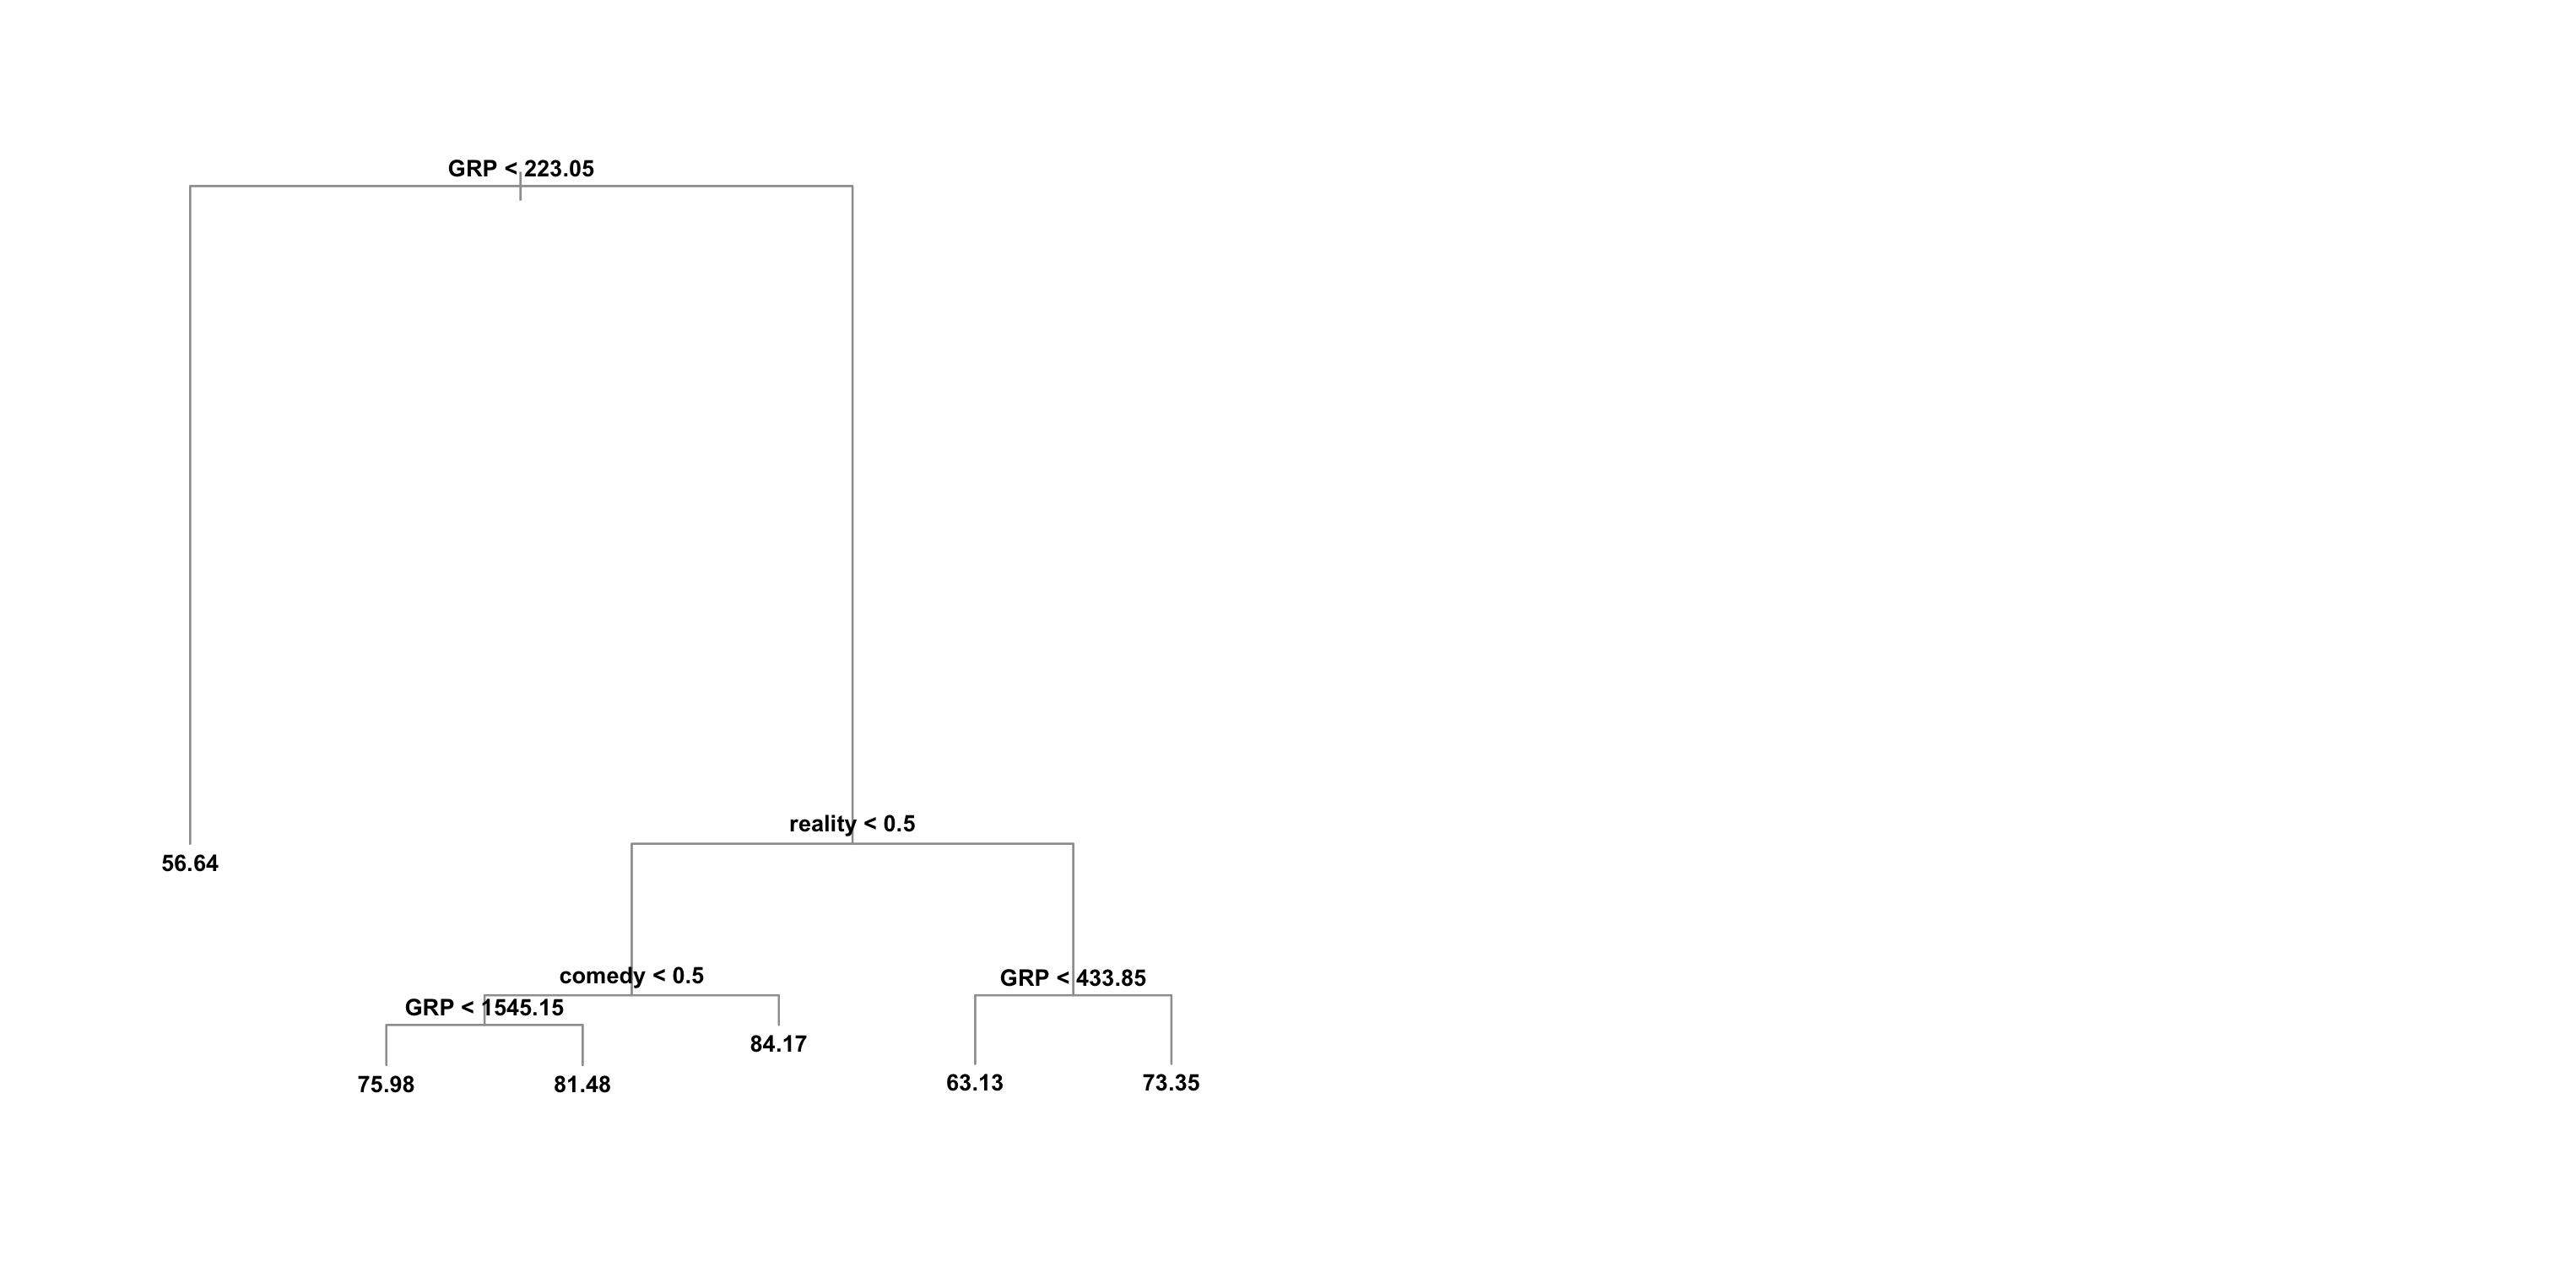

In [15]:
par(mfrow=c(1,2))
plot(nbctree, col=8)
text(nbctree, cex=.75, font=2)

But we can add a look at the fit using the `predict` function.

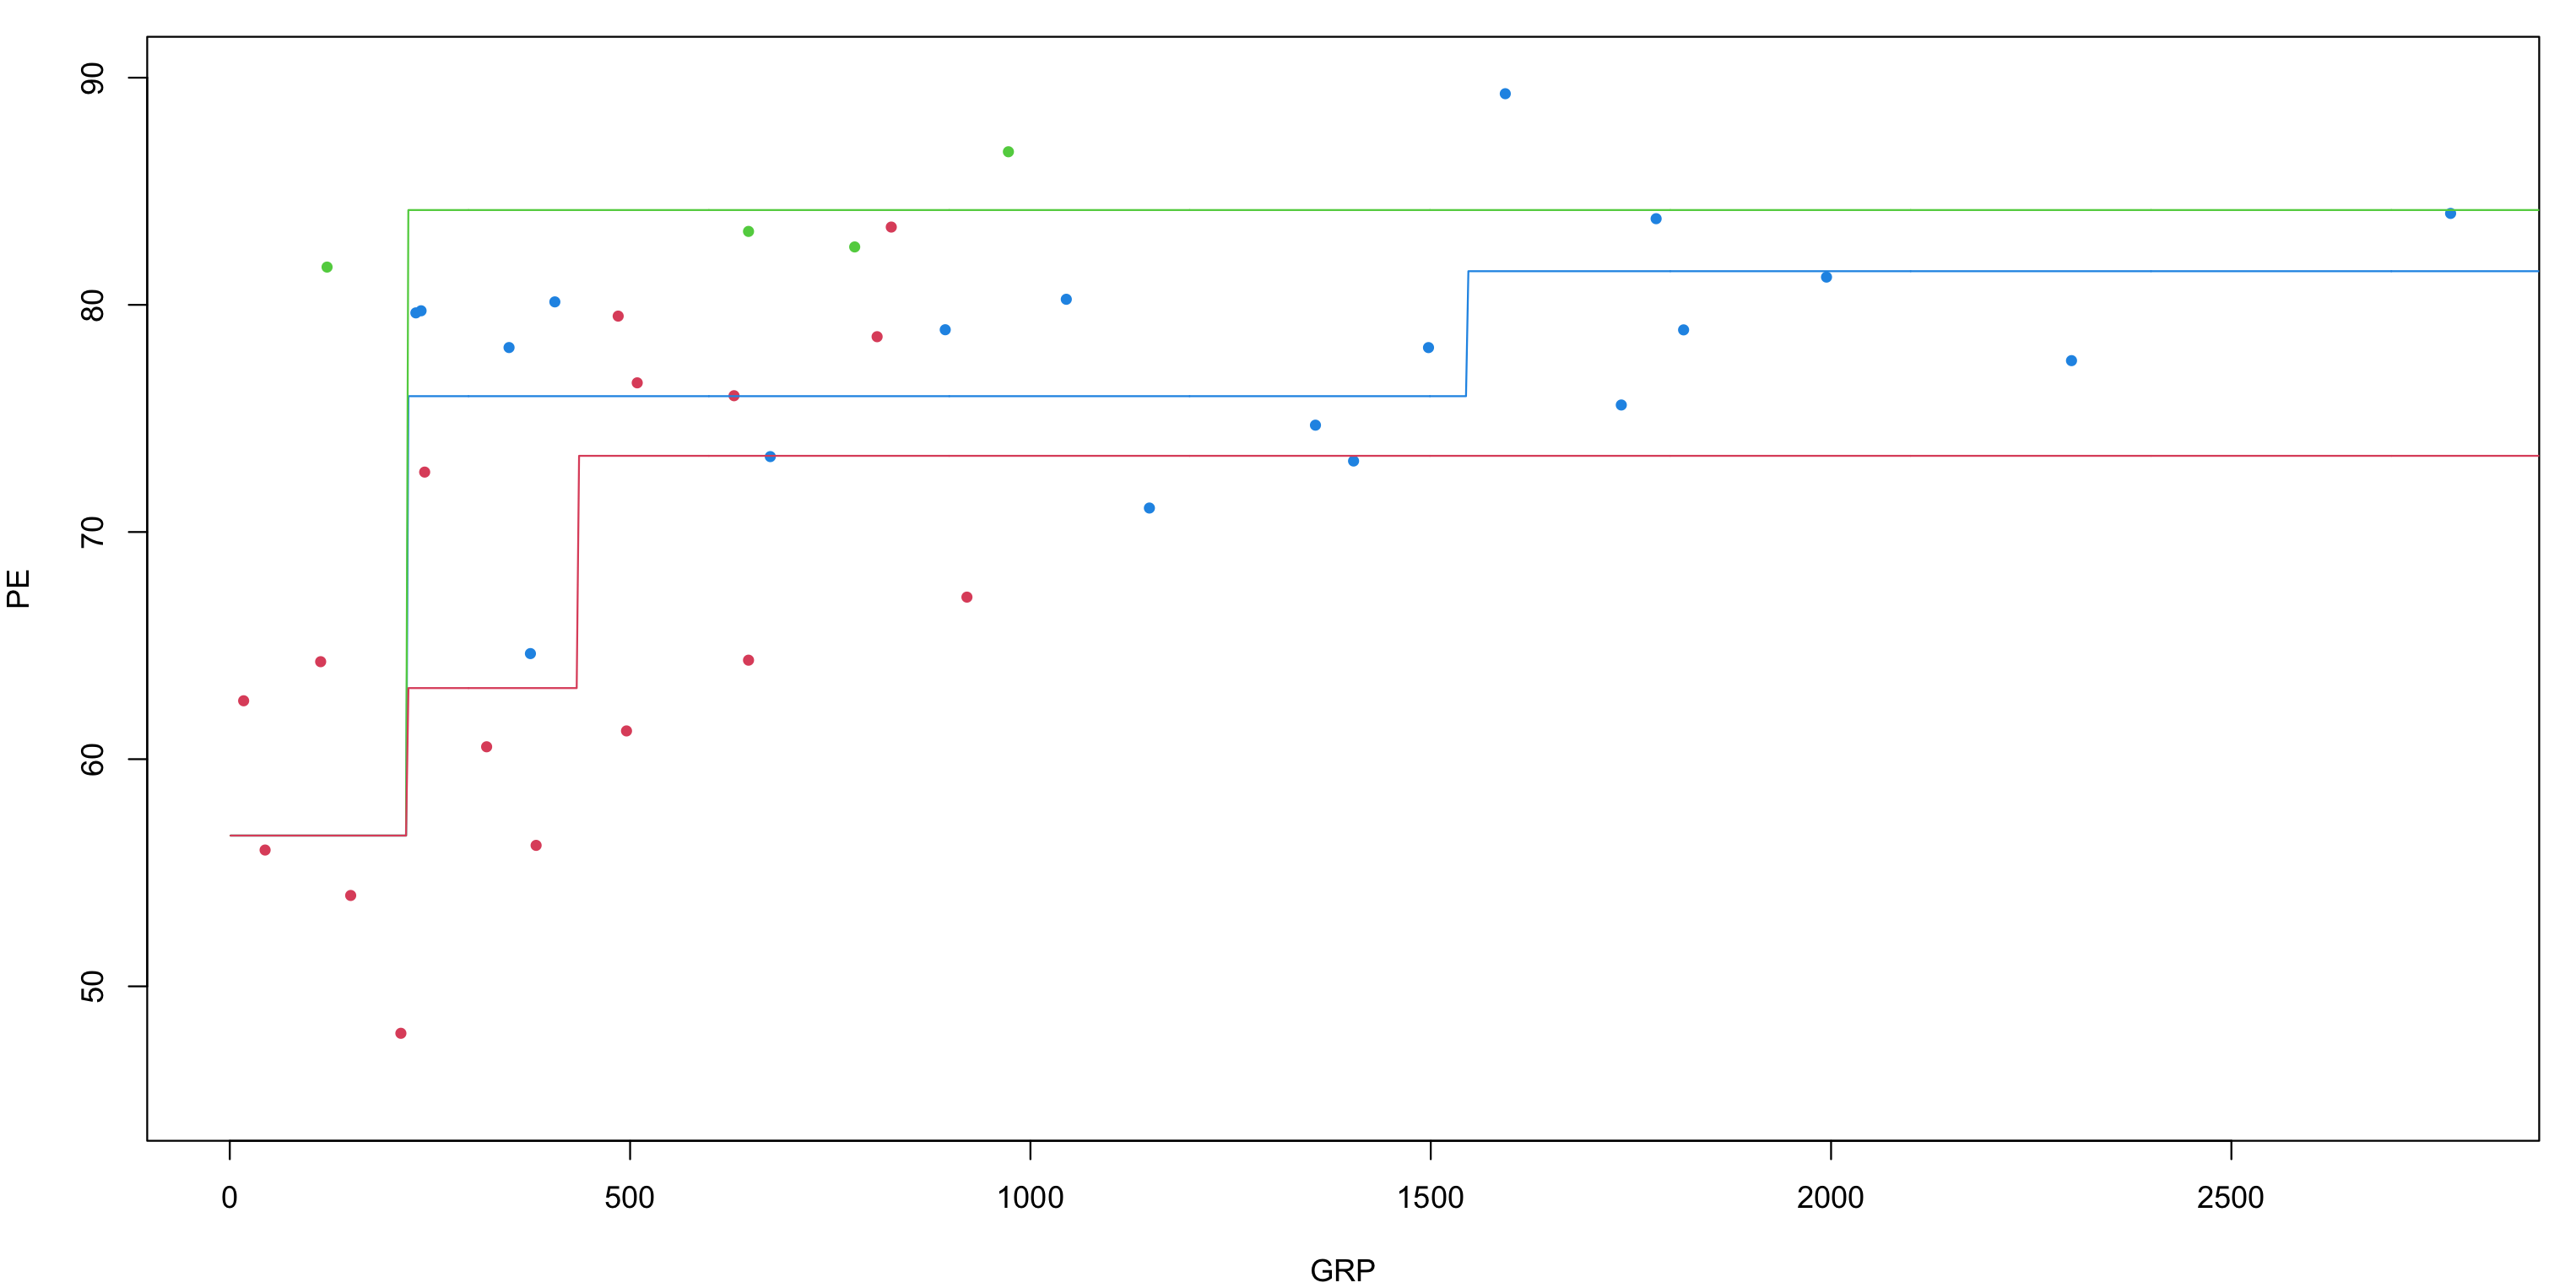

In [16]:
par(mai=c(.8,.8,.2,.2))
plot(PE ~ GRP, data=nbc, col=c(4,2,3)[genre], pch=20, ylim=c(45,90))
newgrp <- seq(1,3000,length=1000)
lines(newgrp, predict(nbctree, newdata=data.frame(GRP=newgrp, drama=1, comedy=0, reality=0)), col=4)
lines(newgrp, predict(nbctree, newdata=data.frame(GRP=newgrp, drama=0, comedy=1, reality=0)), col=3)
lines(newgrp, predict(nbctree, newdata=data.frame(GRP=newgrp, drama=0, comedy=0, reality=1)), col=2)

# Prostate cancer example of CV pruning

We got some new data on cancer biopsies. It's pretty small but we'll run with it. The variables are:
* lcavol: log(cancer volume), the response of interest
* age: age
* lbph: log(benign prostatic hyperplasia amount)
* lcp: log(capsular penetration)
* gleason: Gleason score
* lpsa: log(prostate specific antigen)

In [17]:
prostate <- read.csv("prostate.csv")

Let's fit an overgrown, overly deep, overfit CART first:

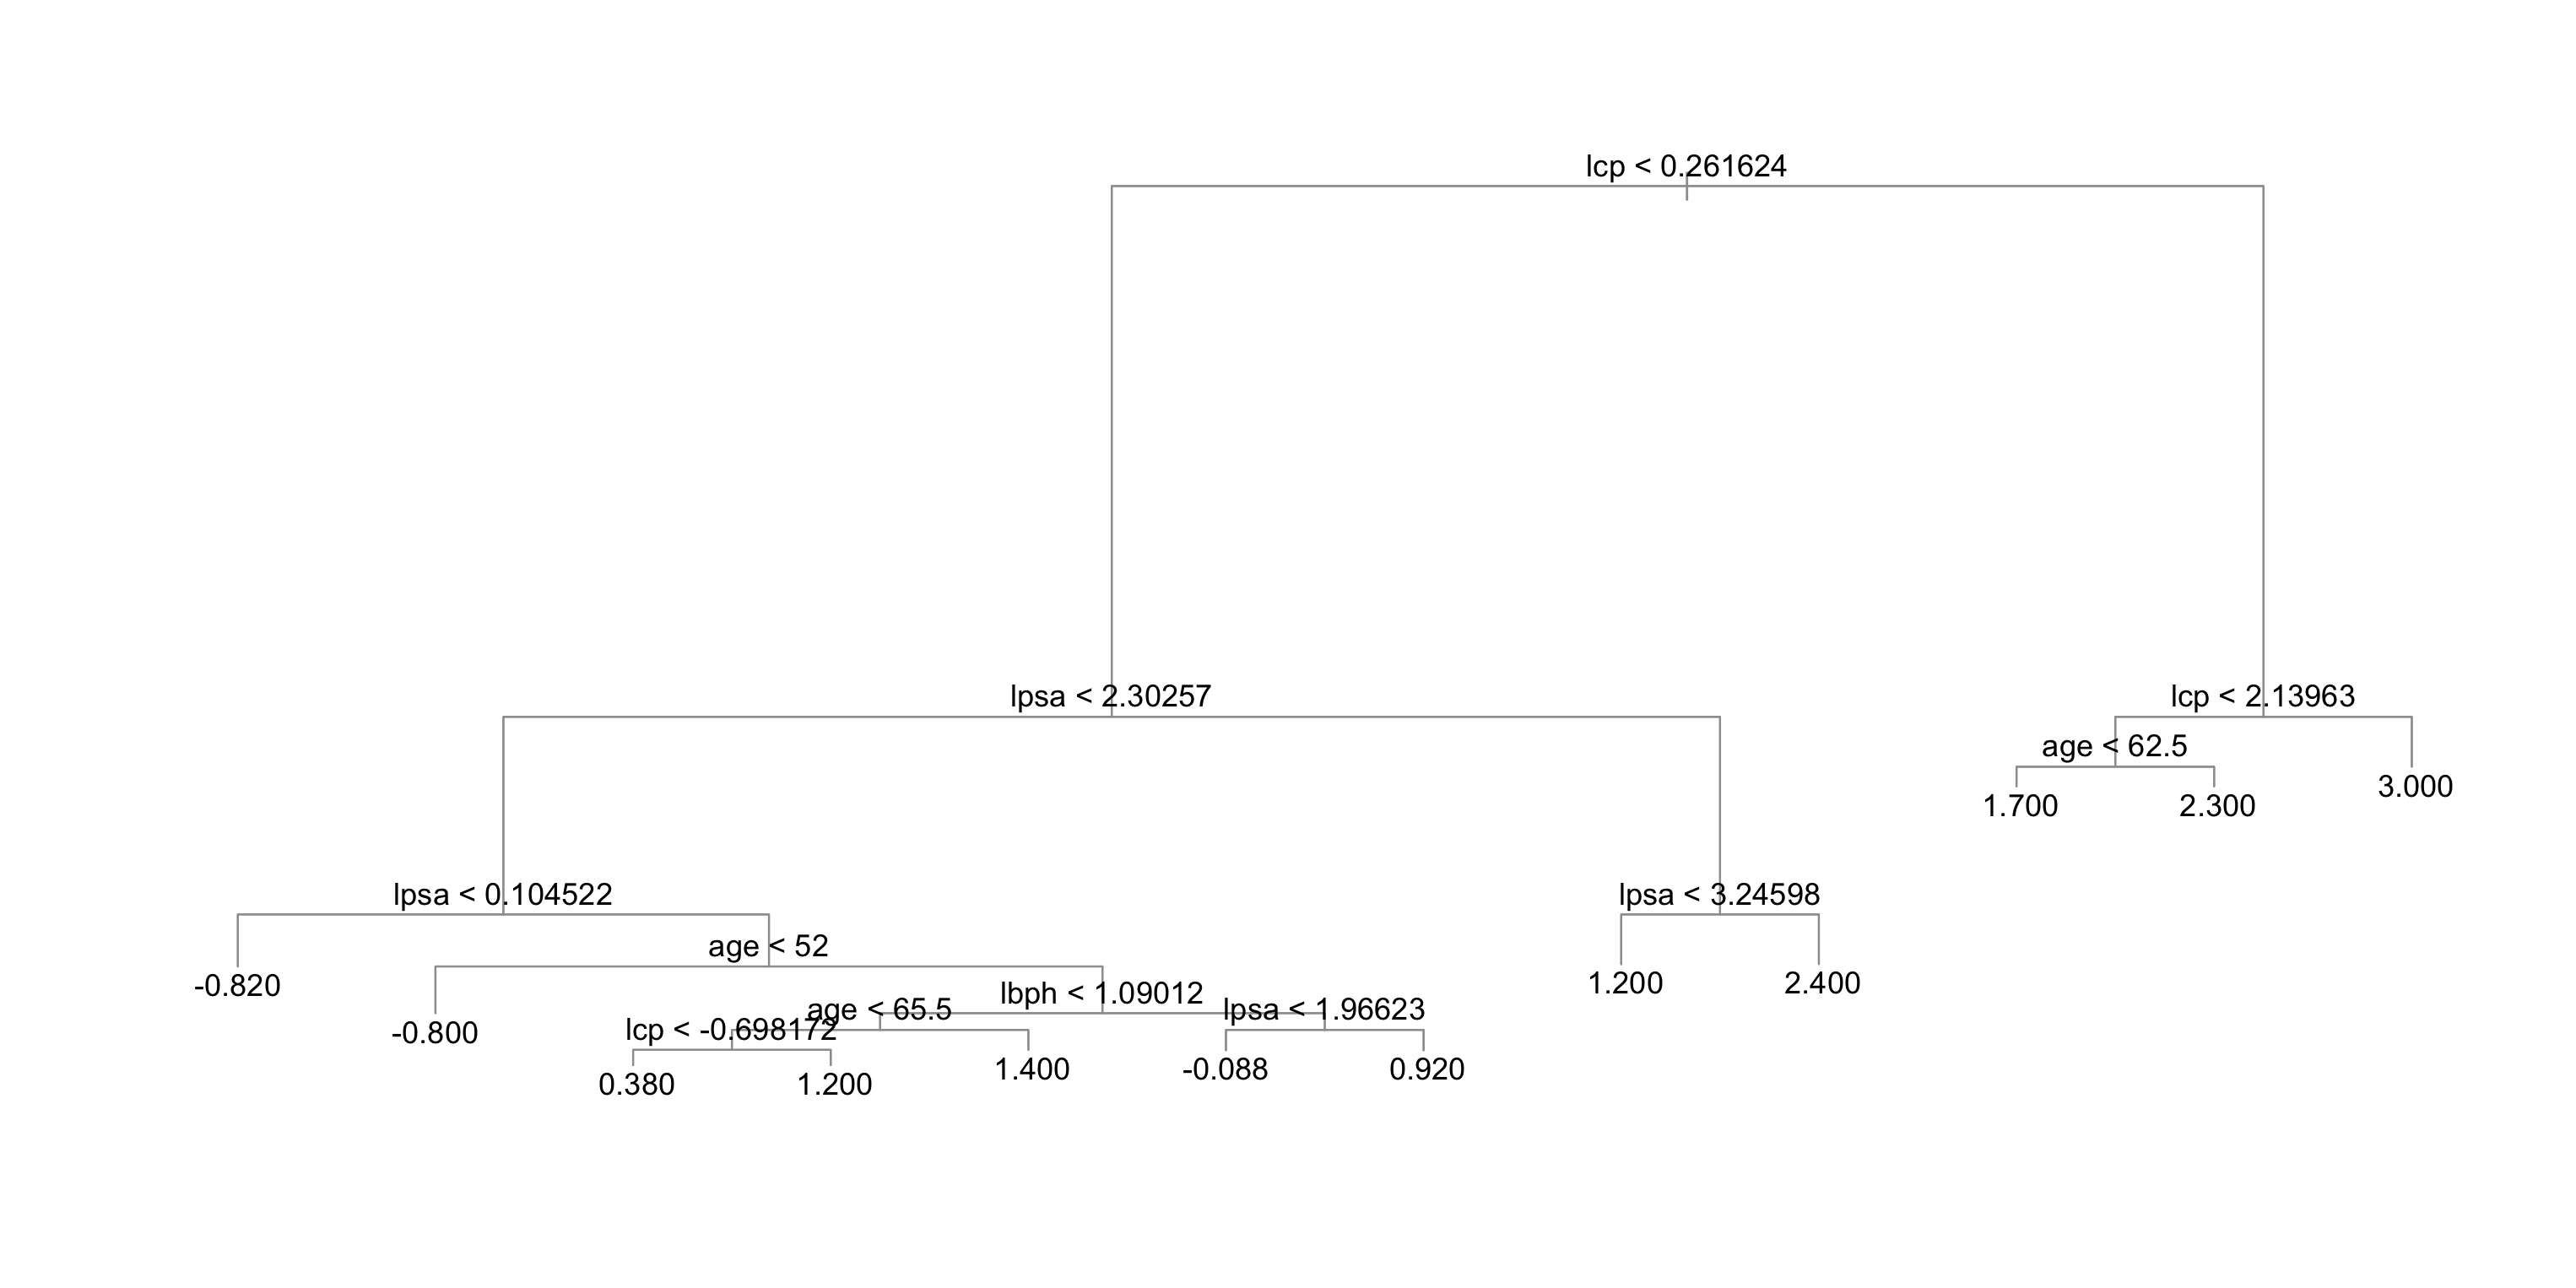

In [18]:
pstree <- tree(lcavol ~., data=prostate, mincut=1)
par(mfrow=c(1,1))
plot(pstree, col=8)
text(pstree, digits=2)

And then use cross-validation to prune the tree.

In [19]:
cvpst <- cv.tree(pstree, K=10)

On Figure 9.5 you can also see what it means that three leaves were the best:

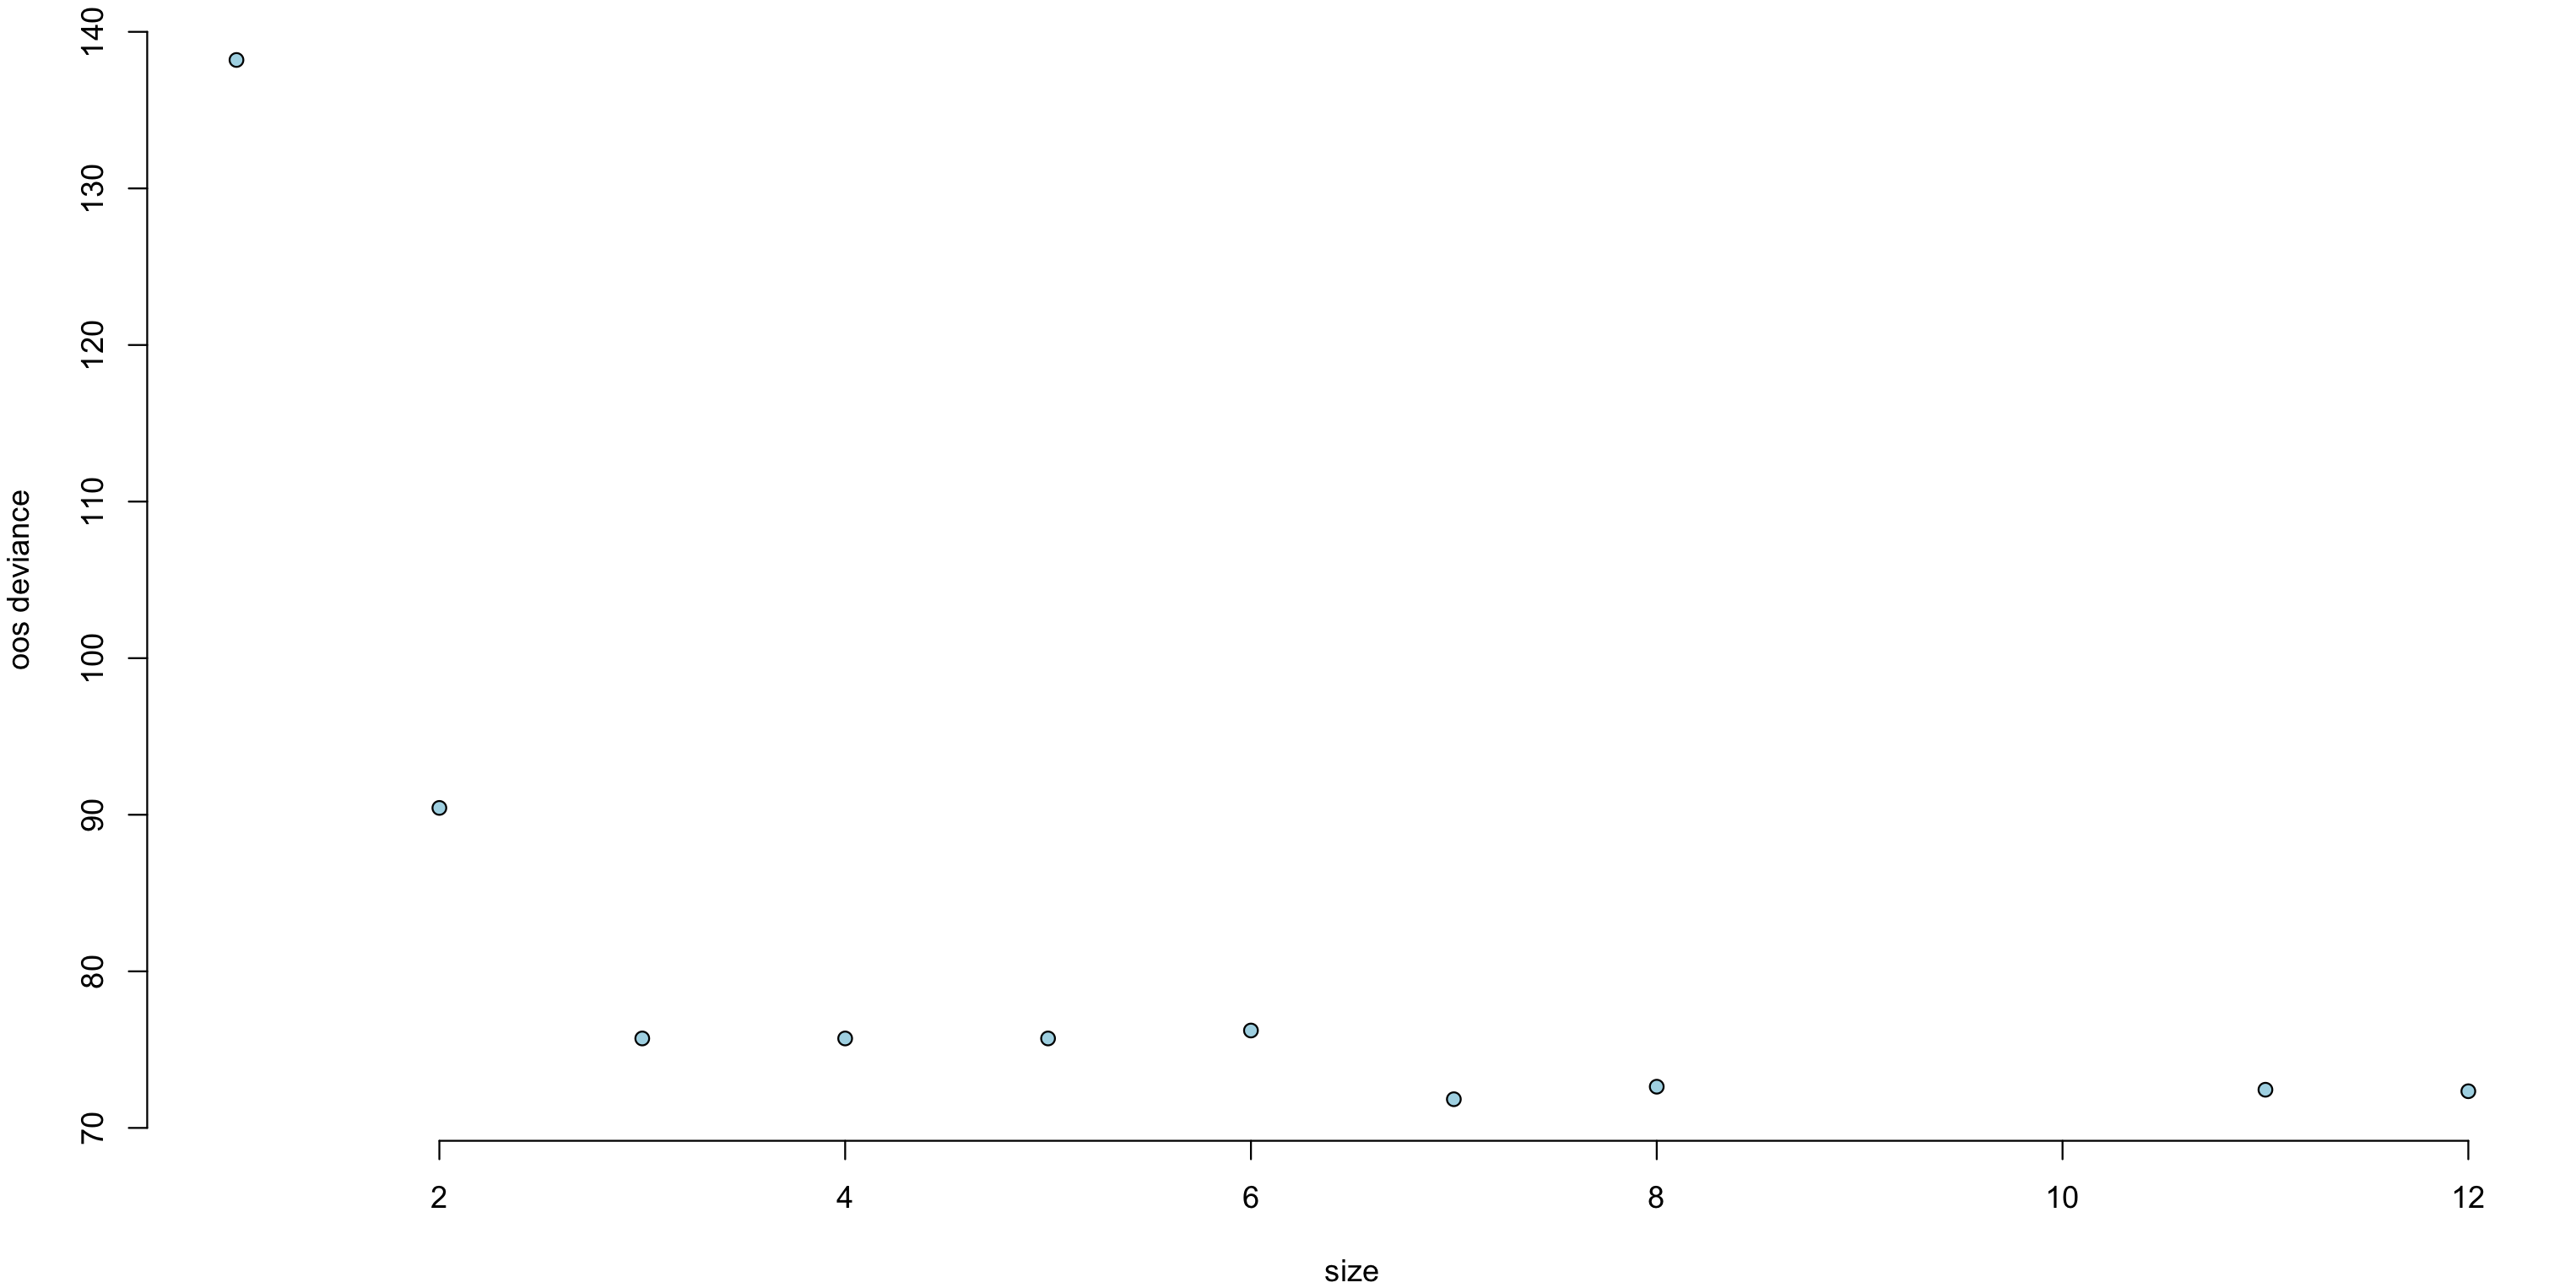

In [20]:
par(mai=c(.8,.8,0.1,0.1))
plot(cvpst$size, cvpst$dev, xlab="size", ylab="oos deviance", pch=21, bg="lightblue", bty="n")

The default plot is similar, but also lists across the top the average number of observations per leaf.

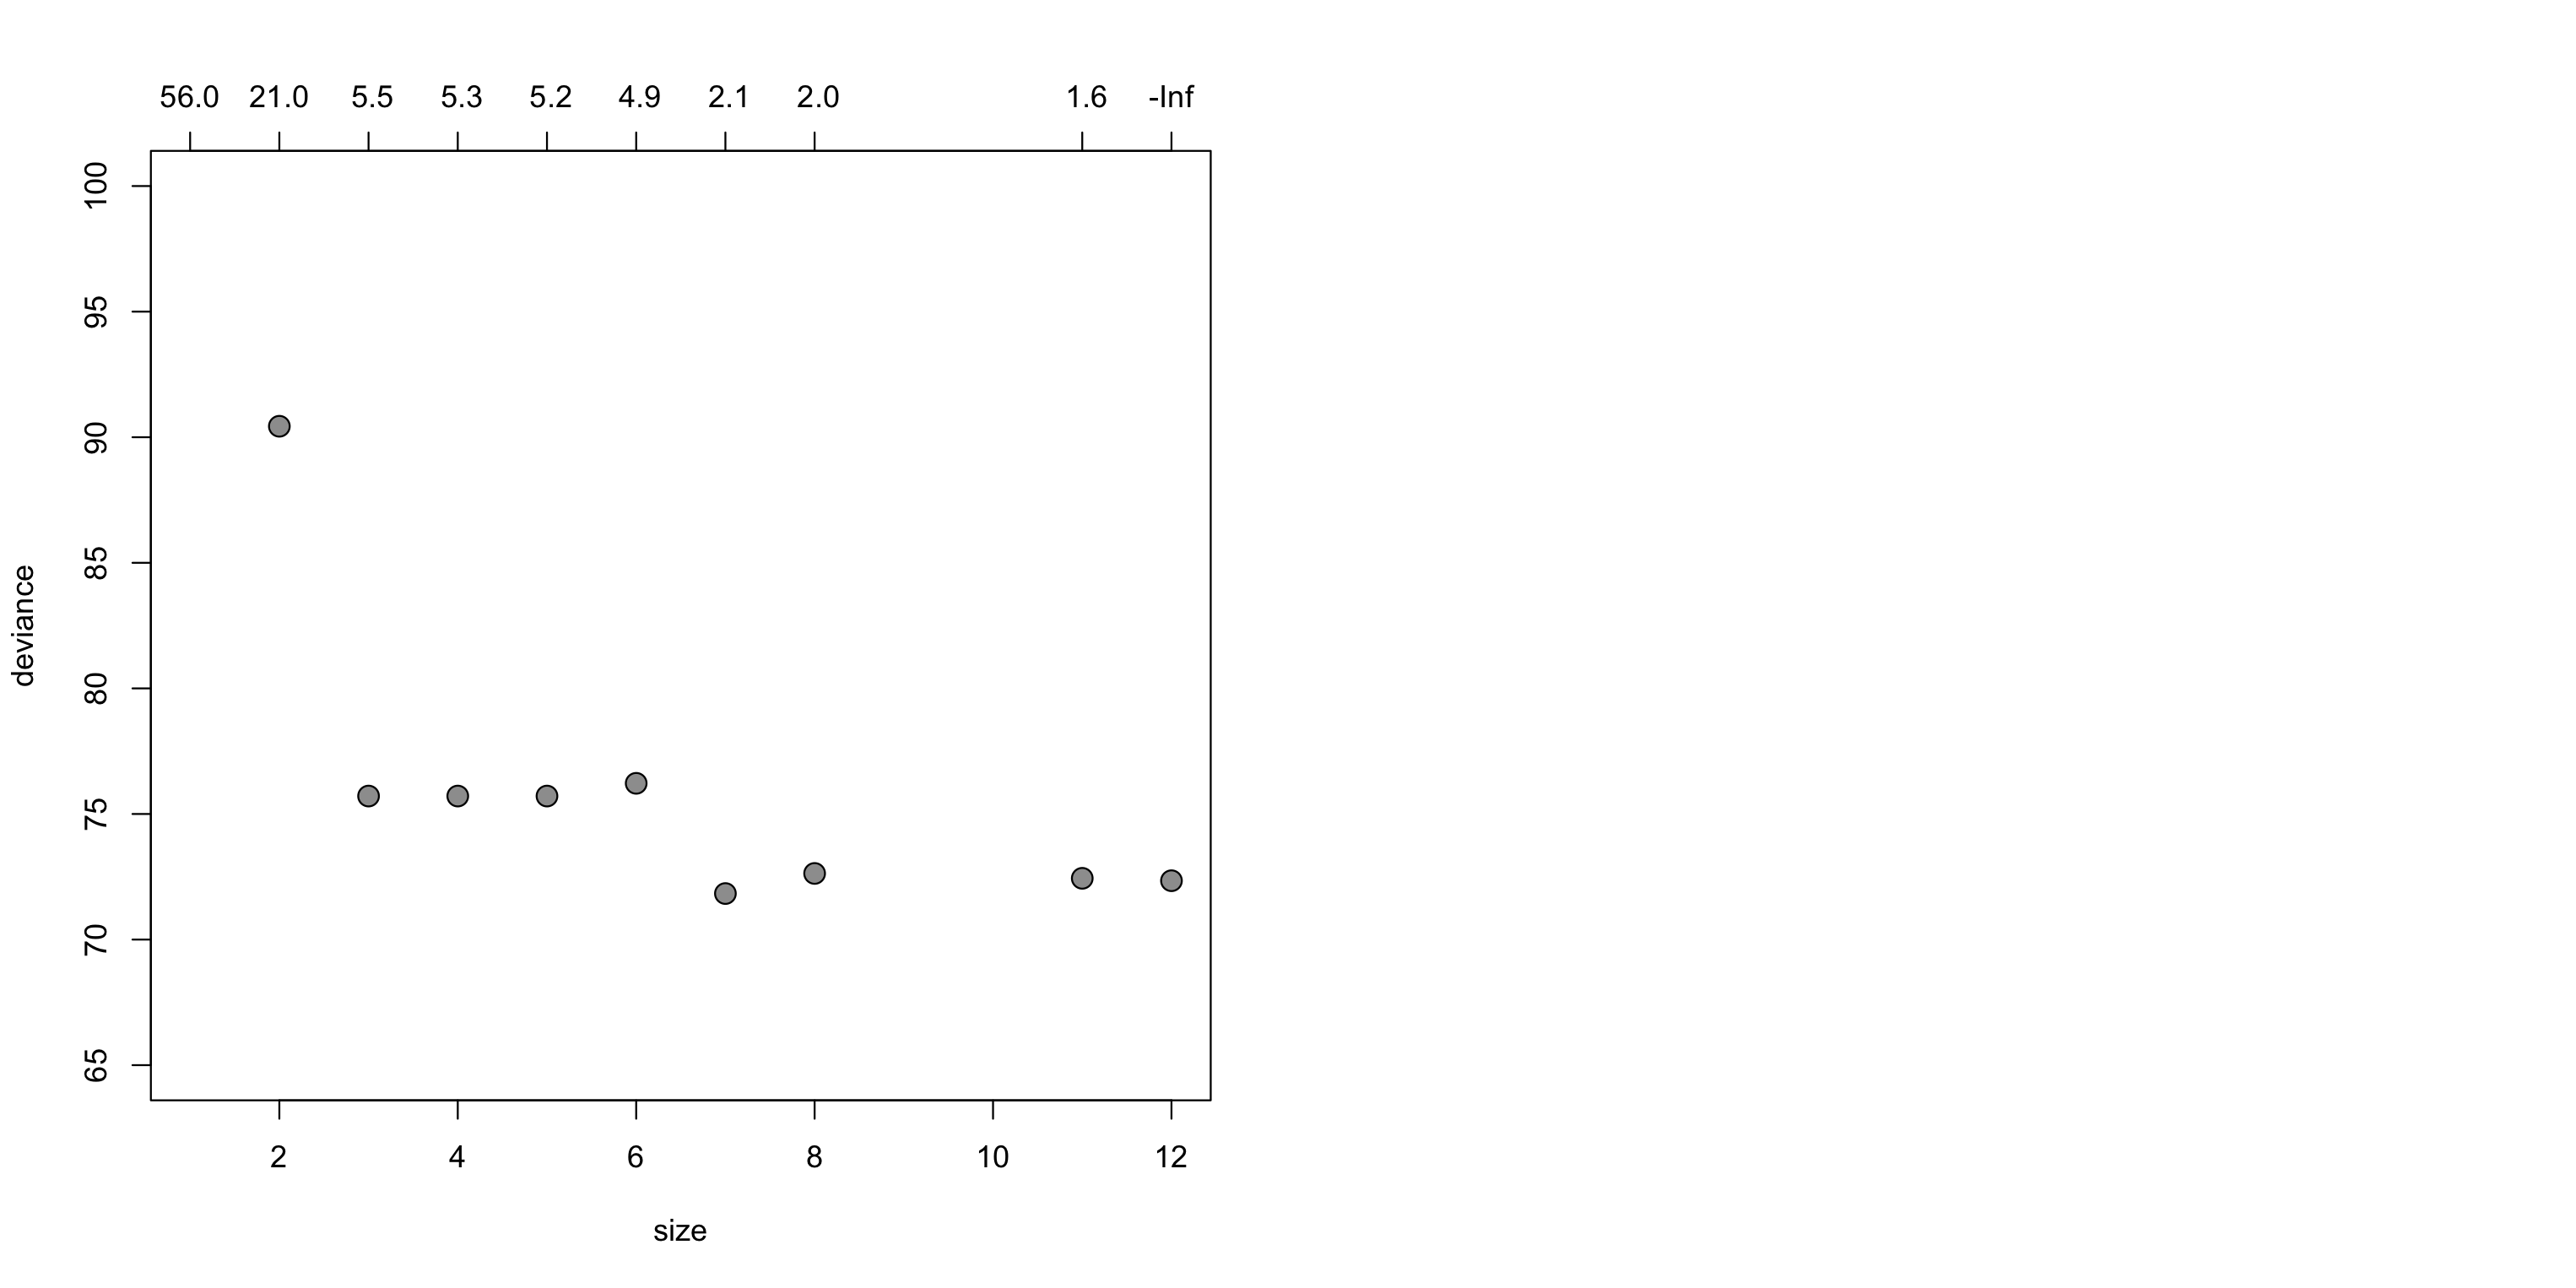

In [21]:
par(mfrow=c(1,2))
plot(cvpst, pch=21, bg=8, type="p", cex=1.5, ylim=c(65,100))

So we can save the pruned tree according to this recommendation.

In [22]:
pstcut <- prune.tree(pstree, best=3)

In Figure 9.6 you can see the dendogram and a pretty intricate summary of the partitioning. The 'response surface' you can understand as the size of the tumors (the size of the bubbles) being different in the three regions defined by the partitions in the lines.

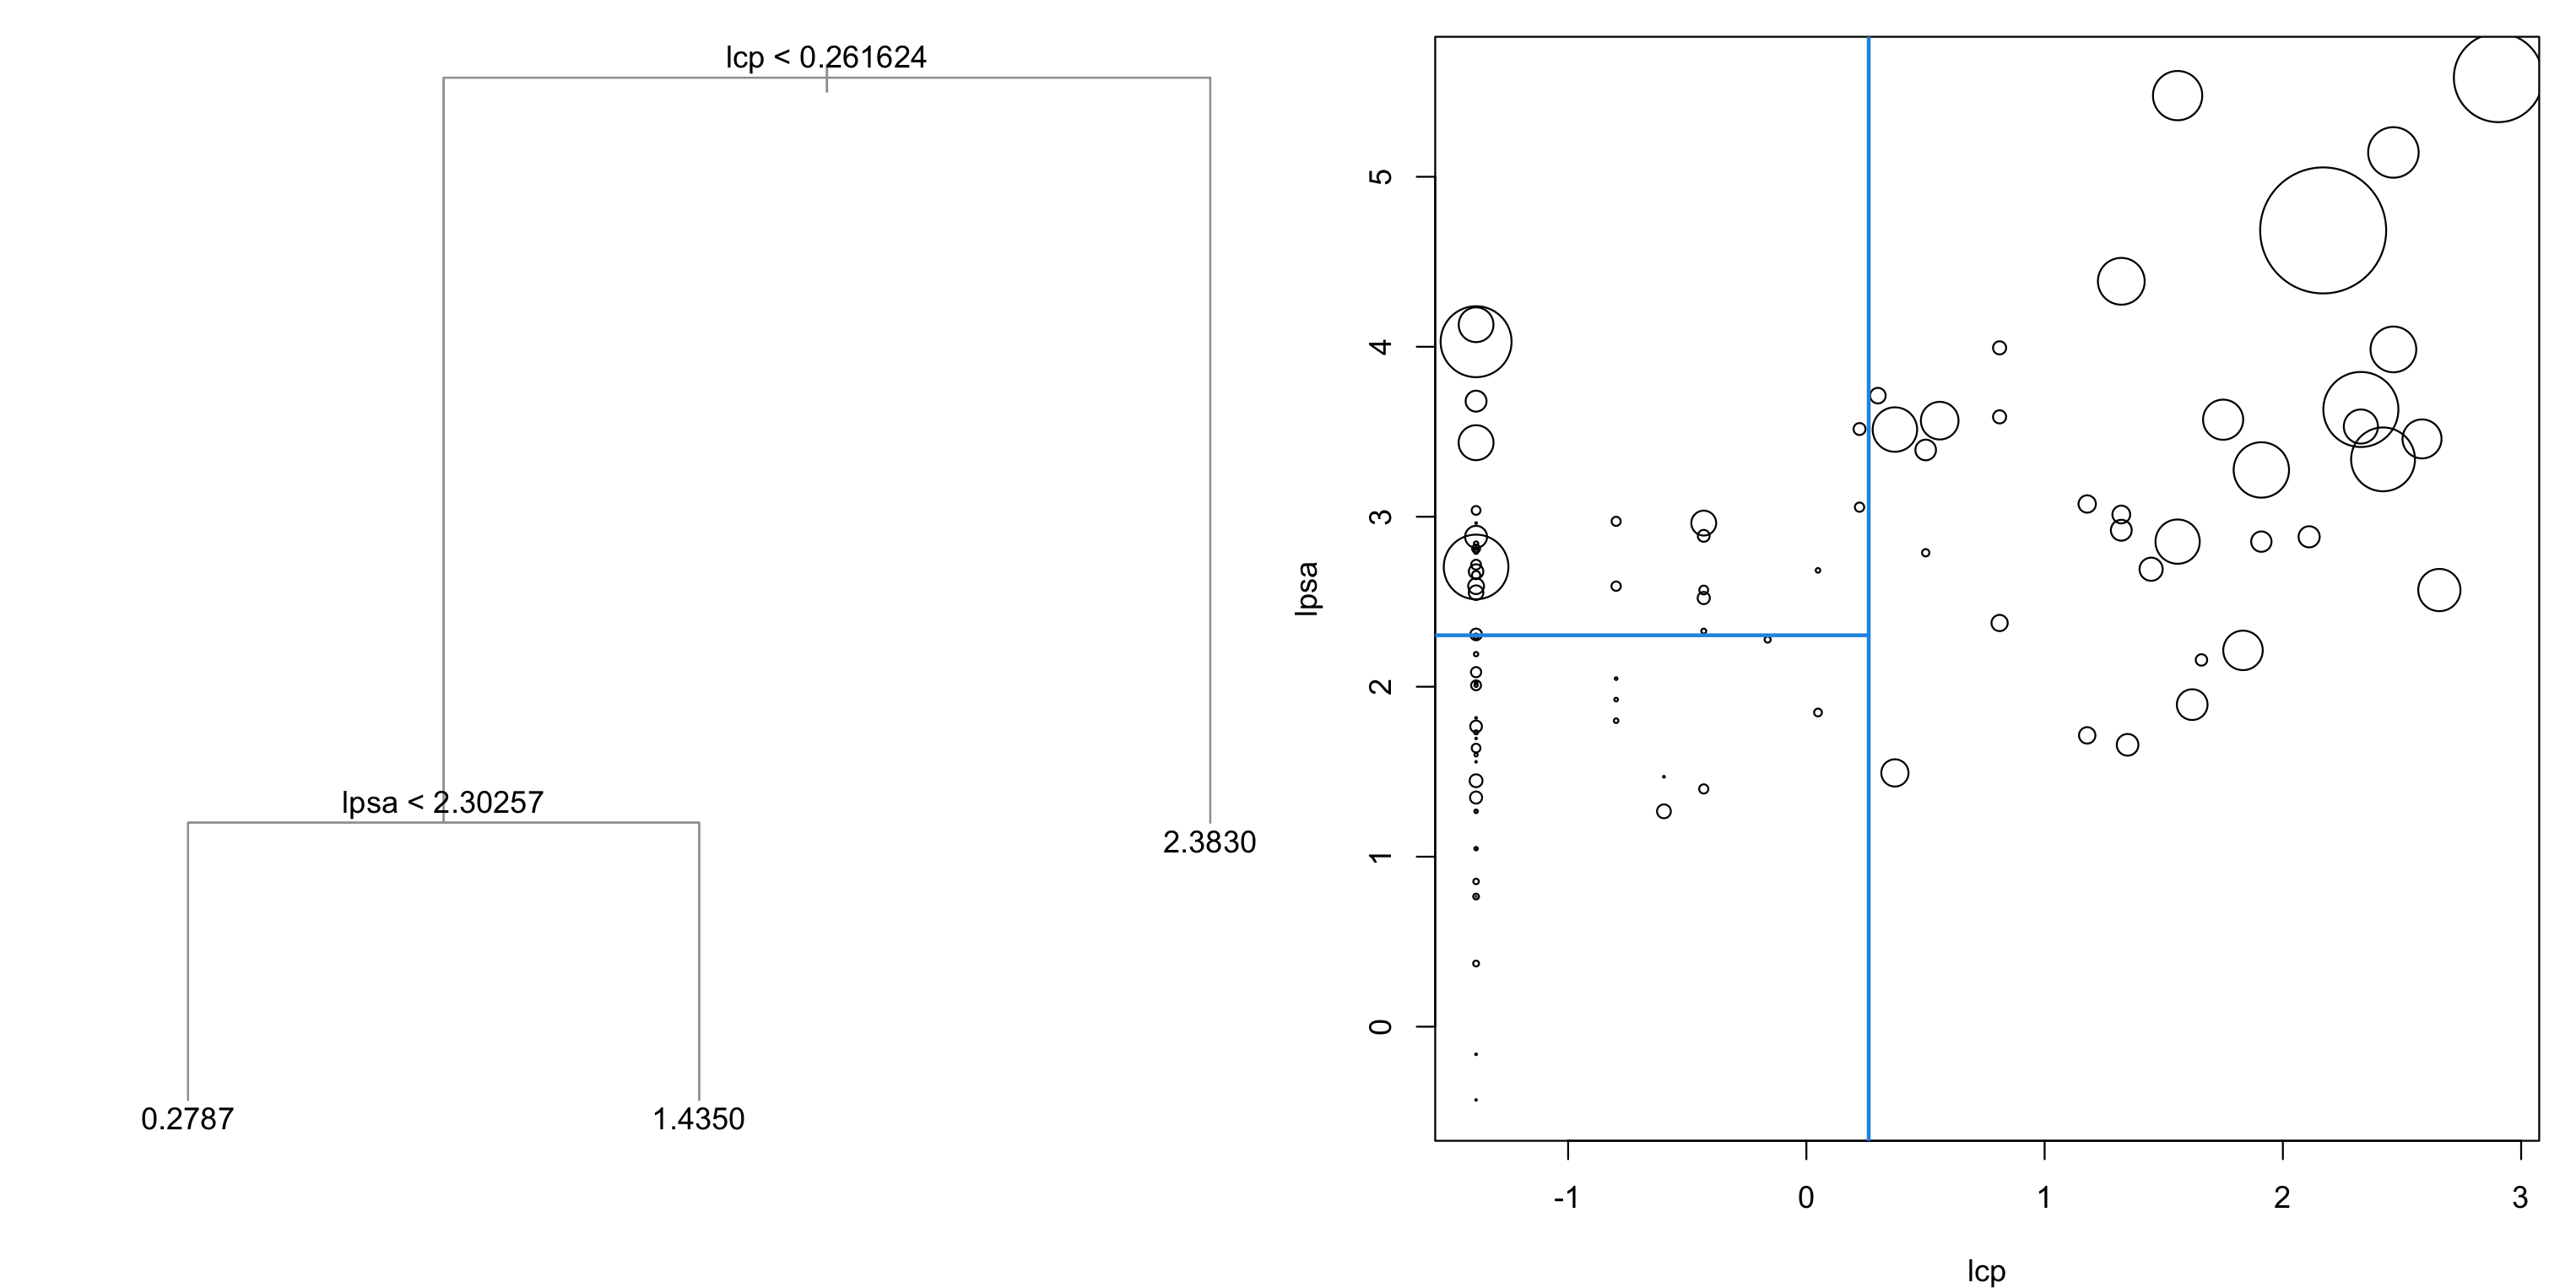

In [23]:
par(mai=c(.8,.8,0.2,0.2), mfrow=c(1,2))
plot(pstcut, col=8)
text(pstcut)
plot(prostate[,c("lcp","lpsa")], cex=exp(prostate$lca)*.2)
abline(v=.261624, col=4, lwd=2)
lines(x=c(-2,.261624), y=c(2.30257,2.30267), col=4, lwd=2)

# Random forests in California housing

We have libraries loaded apart from the faster one for random forests:

In [24]:
library(ranger)


Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance




Let's load some data. We'll focus on median home values in various census tracts (8057 for 39.5 million people). Latitude and longitude are for centroids of the tract. Our response value will be `log(medianhomeval)`.

In [25]:
CAhousing <- read.csv("CAhousing.csv")
CAhousing$AveBedrms <- CAhousing$totalBedrooms/CAhousing$households
CAhousing$AveRooms <- CAhousing$totalRooms/CAhousing$households
CAhousing$AveOccupancy <- CAhousing$population/CAhousing$households
logMedVal <- log(CAhousing$medianHouseValue)

Actually, we can drop the original median from the data frame, and room totals just as much. This can free up some memory, or maybe more importantly let us use shorthands more easily. We could also attach the log median value for similar reasons.

In [26]:
CAhousing <- CAhousing[,-c(4,5,9)]
#CAhousing$logMedVal <- logMedVal

In [27]:
head(CAhousing)

longitude latitude housingMedianAge population households medianIncome
1 -122.23   37.88    41                322        126       8.3252      
2 -122.22   37.86    21               2401       1138       8.3014      
3 -122.24   37.85    52                496        177       7.2574      
4 -122.25   37.85    52                558        219       5.6431      
5 -122.25   37.85    52                565        259       3.8462      
6 -122.25   37.85    52                413        193       4.0368      
  AveBedrms AveRooms AveOccupancy
1 1.0238095 6.984127 2.555556    
2 0.9718805 6.238137 2.109842    
3 1.0734463 8.288136 2.802260    
4 1.0730594 5.817352 2.547945    
5 1.0810811 6.281853 2.181467    
6 1.1036269 4.761658 2.139896

For a linear model we'll also fit for comparison, we'll need a full design matrix with interactions. Be careful that we are normalizing the outcome variable.

In [28]:
XXca <- model.matrix(~.*longitude*latitude, data=data.frame(scale(CAhousing)))[,-1]

Here comes said linear model. It gets quite complicated. (Note that we are not making it easy: probably area fixed effects could have helped here. Let's stay away from them for now, they are also not really "parametric".)

32 x 1 sparse Matrix of class "dgCMatrix"
                                    seg46
intercept                           12.08
longitude                           -0.51
latitude                            -0.56
housingMedianAge                     0.04
population                          -0.16
households                           0.19
medianIncome                         0.31
AveBedrms                            .   
AveRooms                             .   
AveOccupancy                         .   
longitude:latitude                   .   
longitude:housingMedianAge          -0.06
longitude:population                 .   
longitude:households                 .   
longitude:medianIncome               0.00
longitude:AveBedrms                  0.01
longitude:AveRooms                   0.01
longitude:AveOccupancy               .   
latitude:housingMedianAge           -0.07
latitude:population                  .   
latitude:households                  .   
latitude:medianIncome             

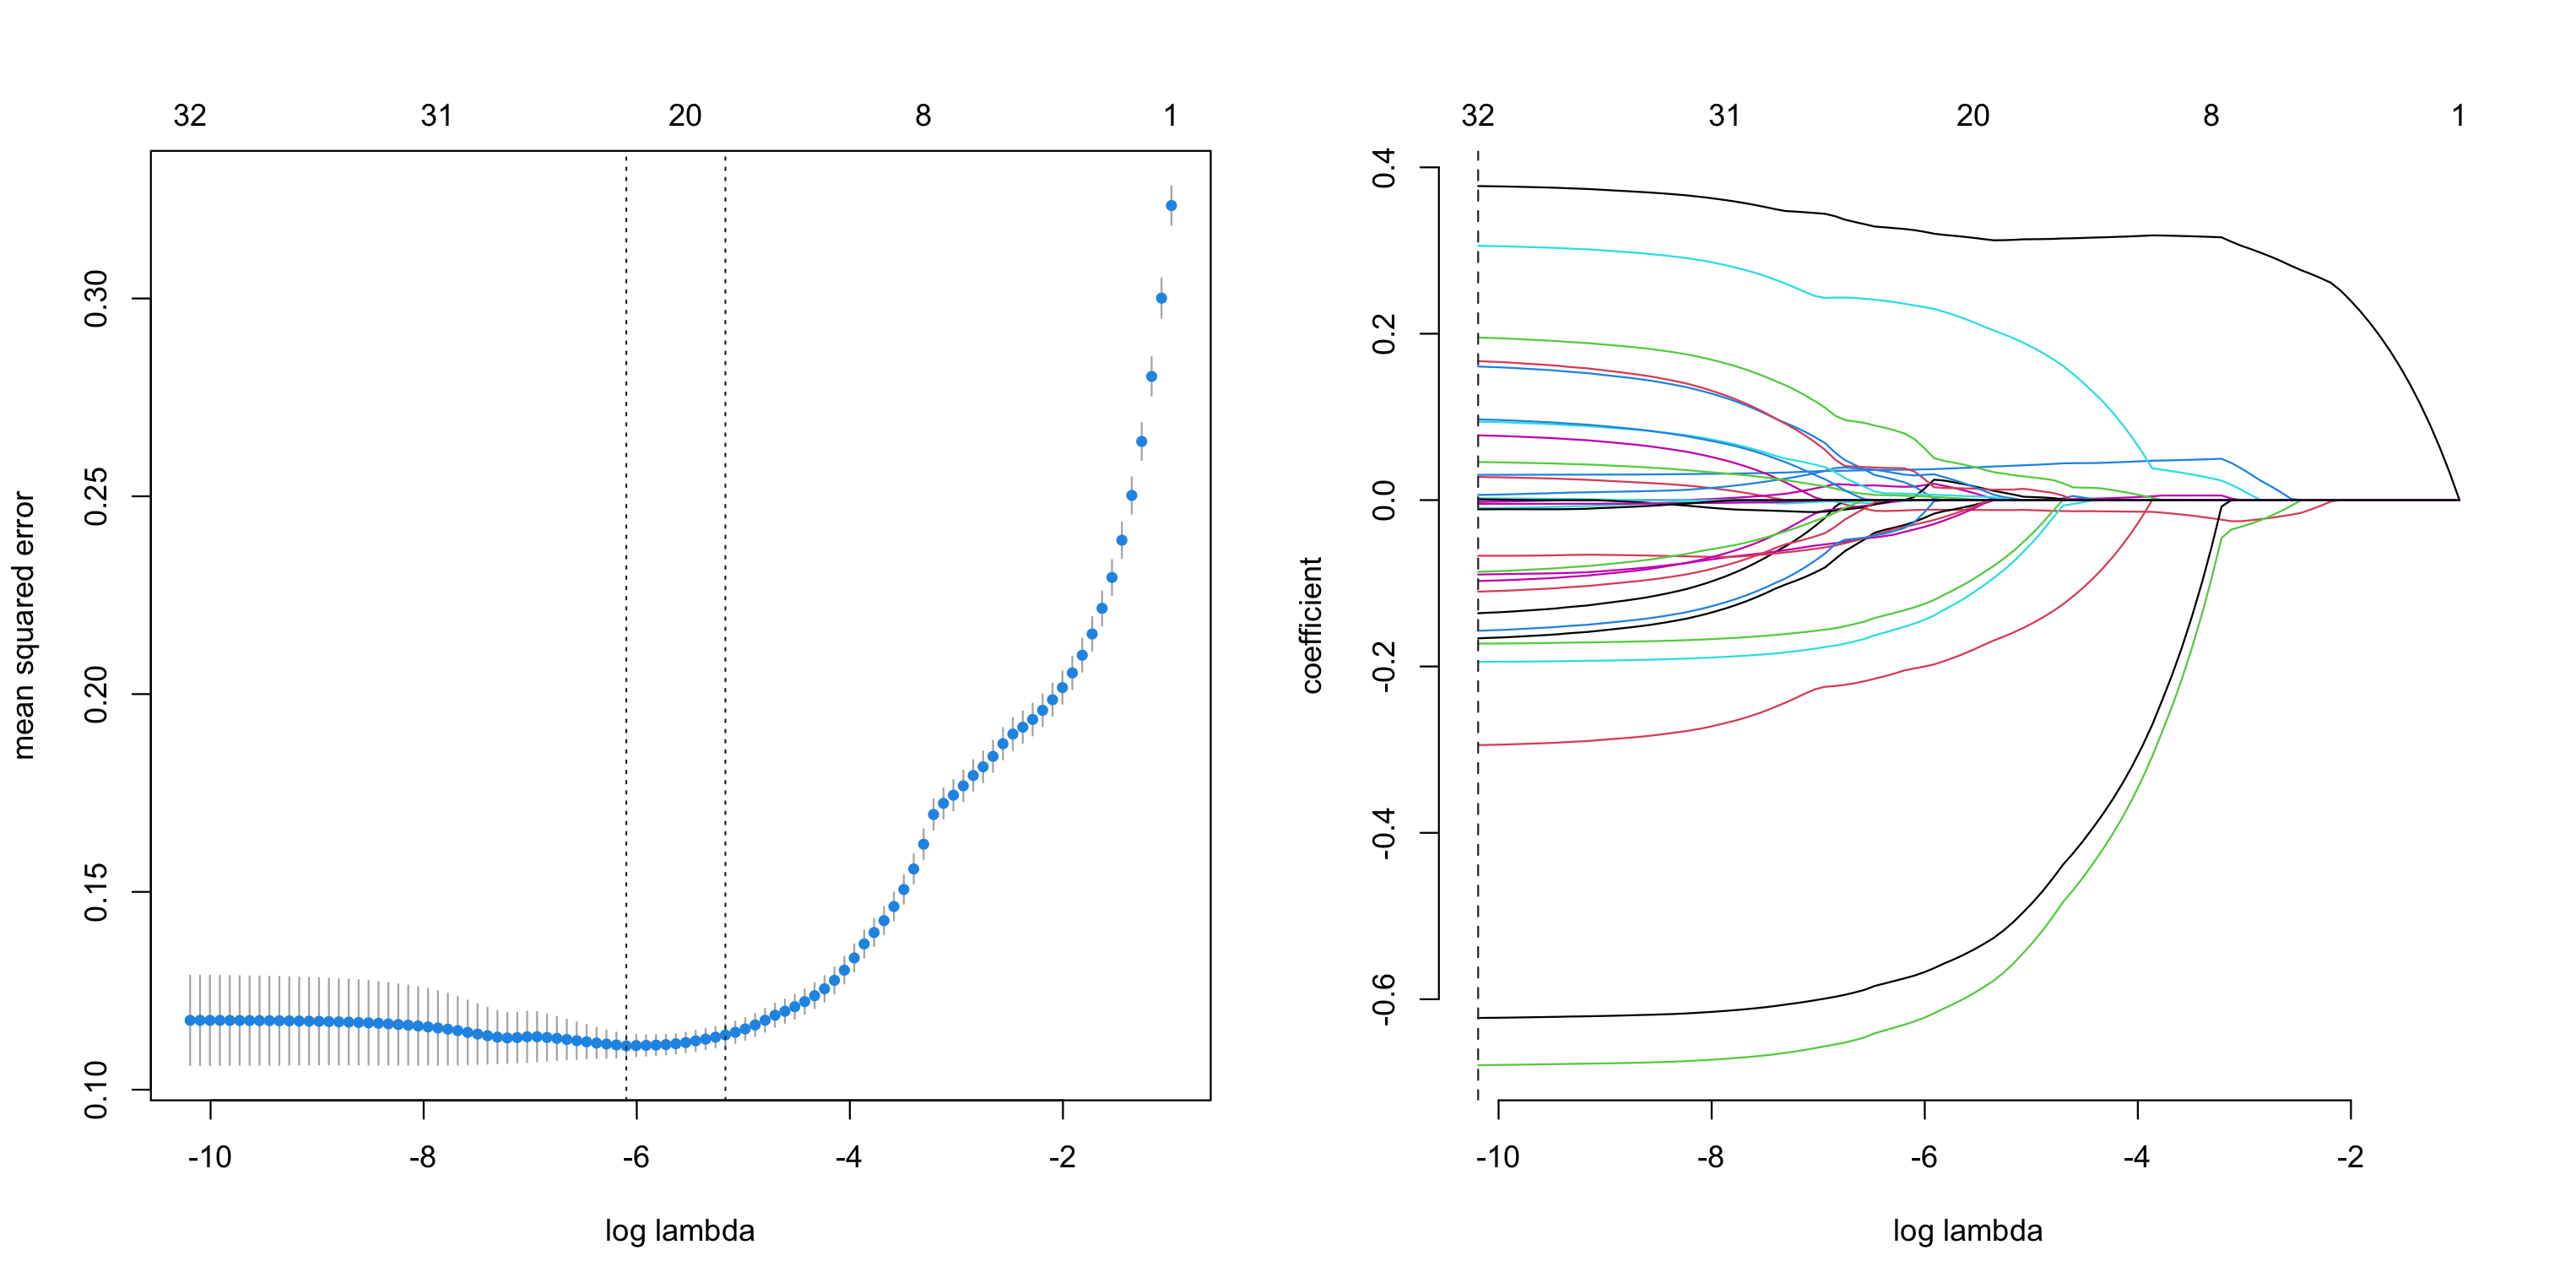

In [29]:
par(mfrow=c(1,2))
plot(calasso <- cv.gamlr(x=XXca, y=logMedVal, lmr=1e-4))
plot(calasso$gamlr)
round(coef(calasso),2)

Compare this with trees.

First, lets do it with CART.
Note there is no need for interactions; the tree finds them automatically.

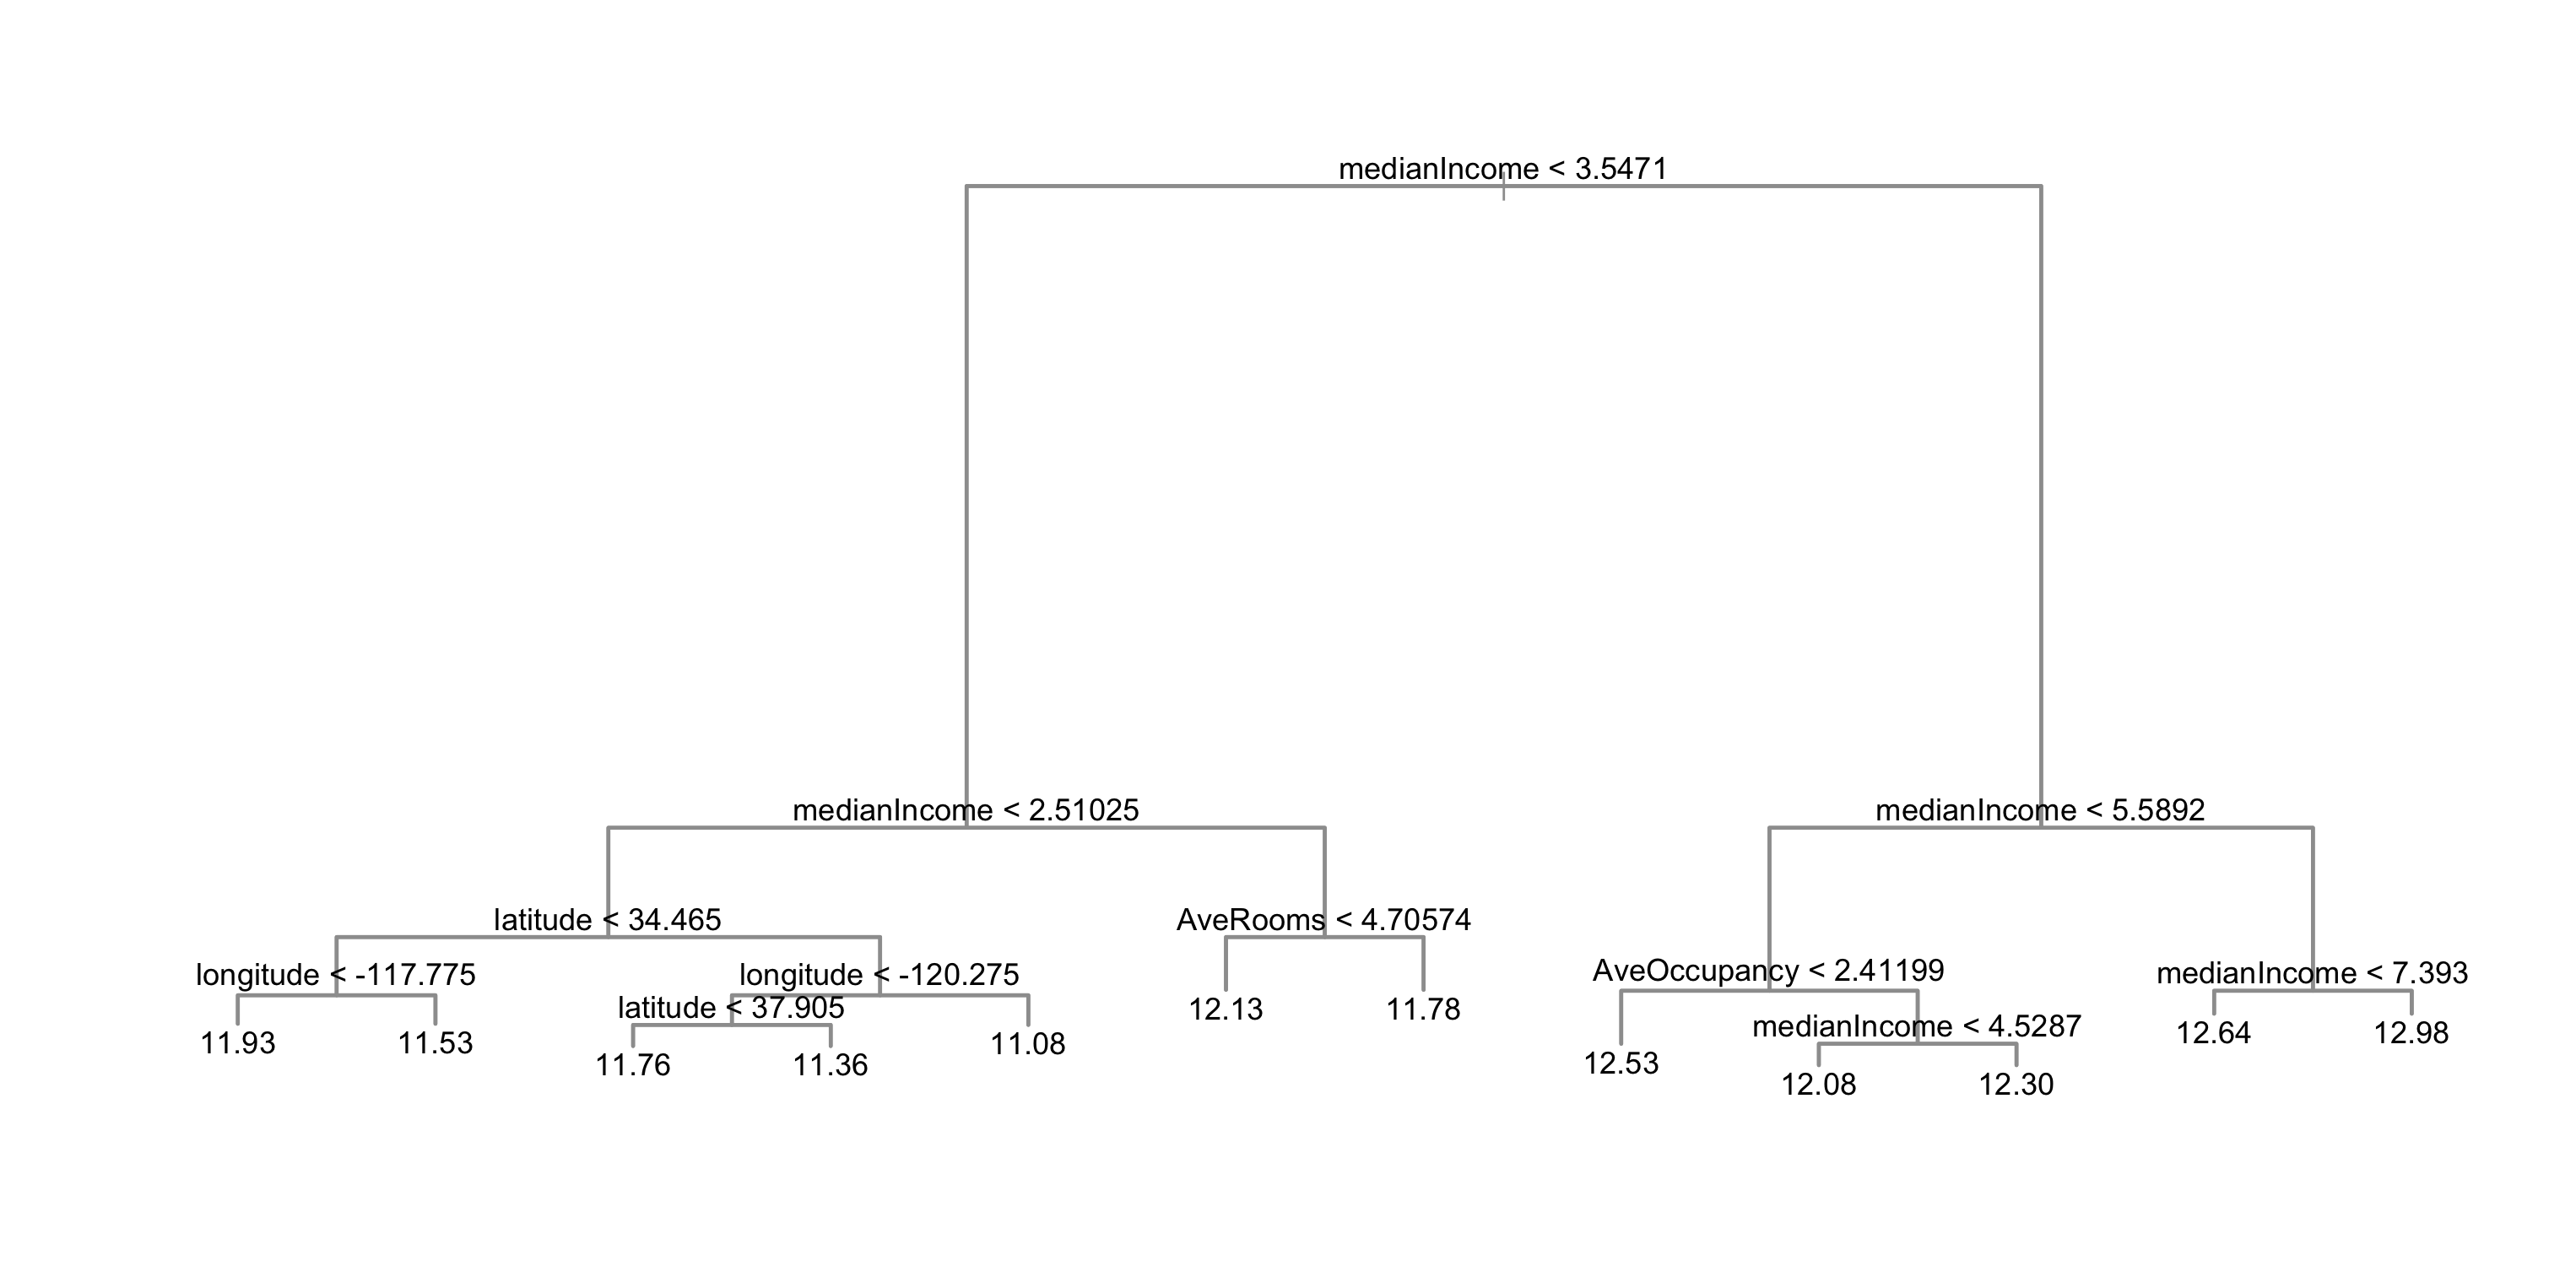

In [30]:
catree <- tree(logMedVal ~ ., data=CAhousing) 
plot(catree, col=8, lwd=2)
text(catree)

With  cross-validation, it does not even look like with overiftted. The most complicated tree is best! 

[1] 12

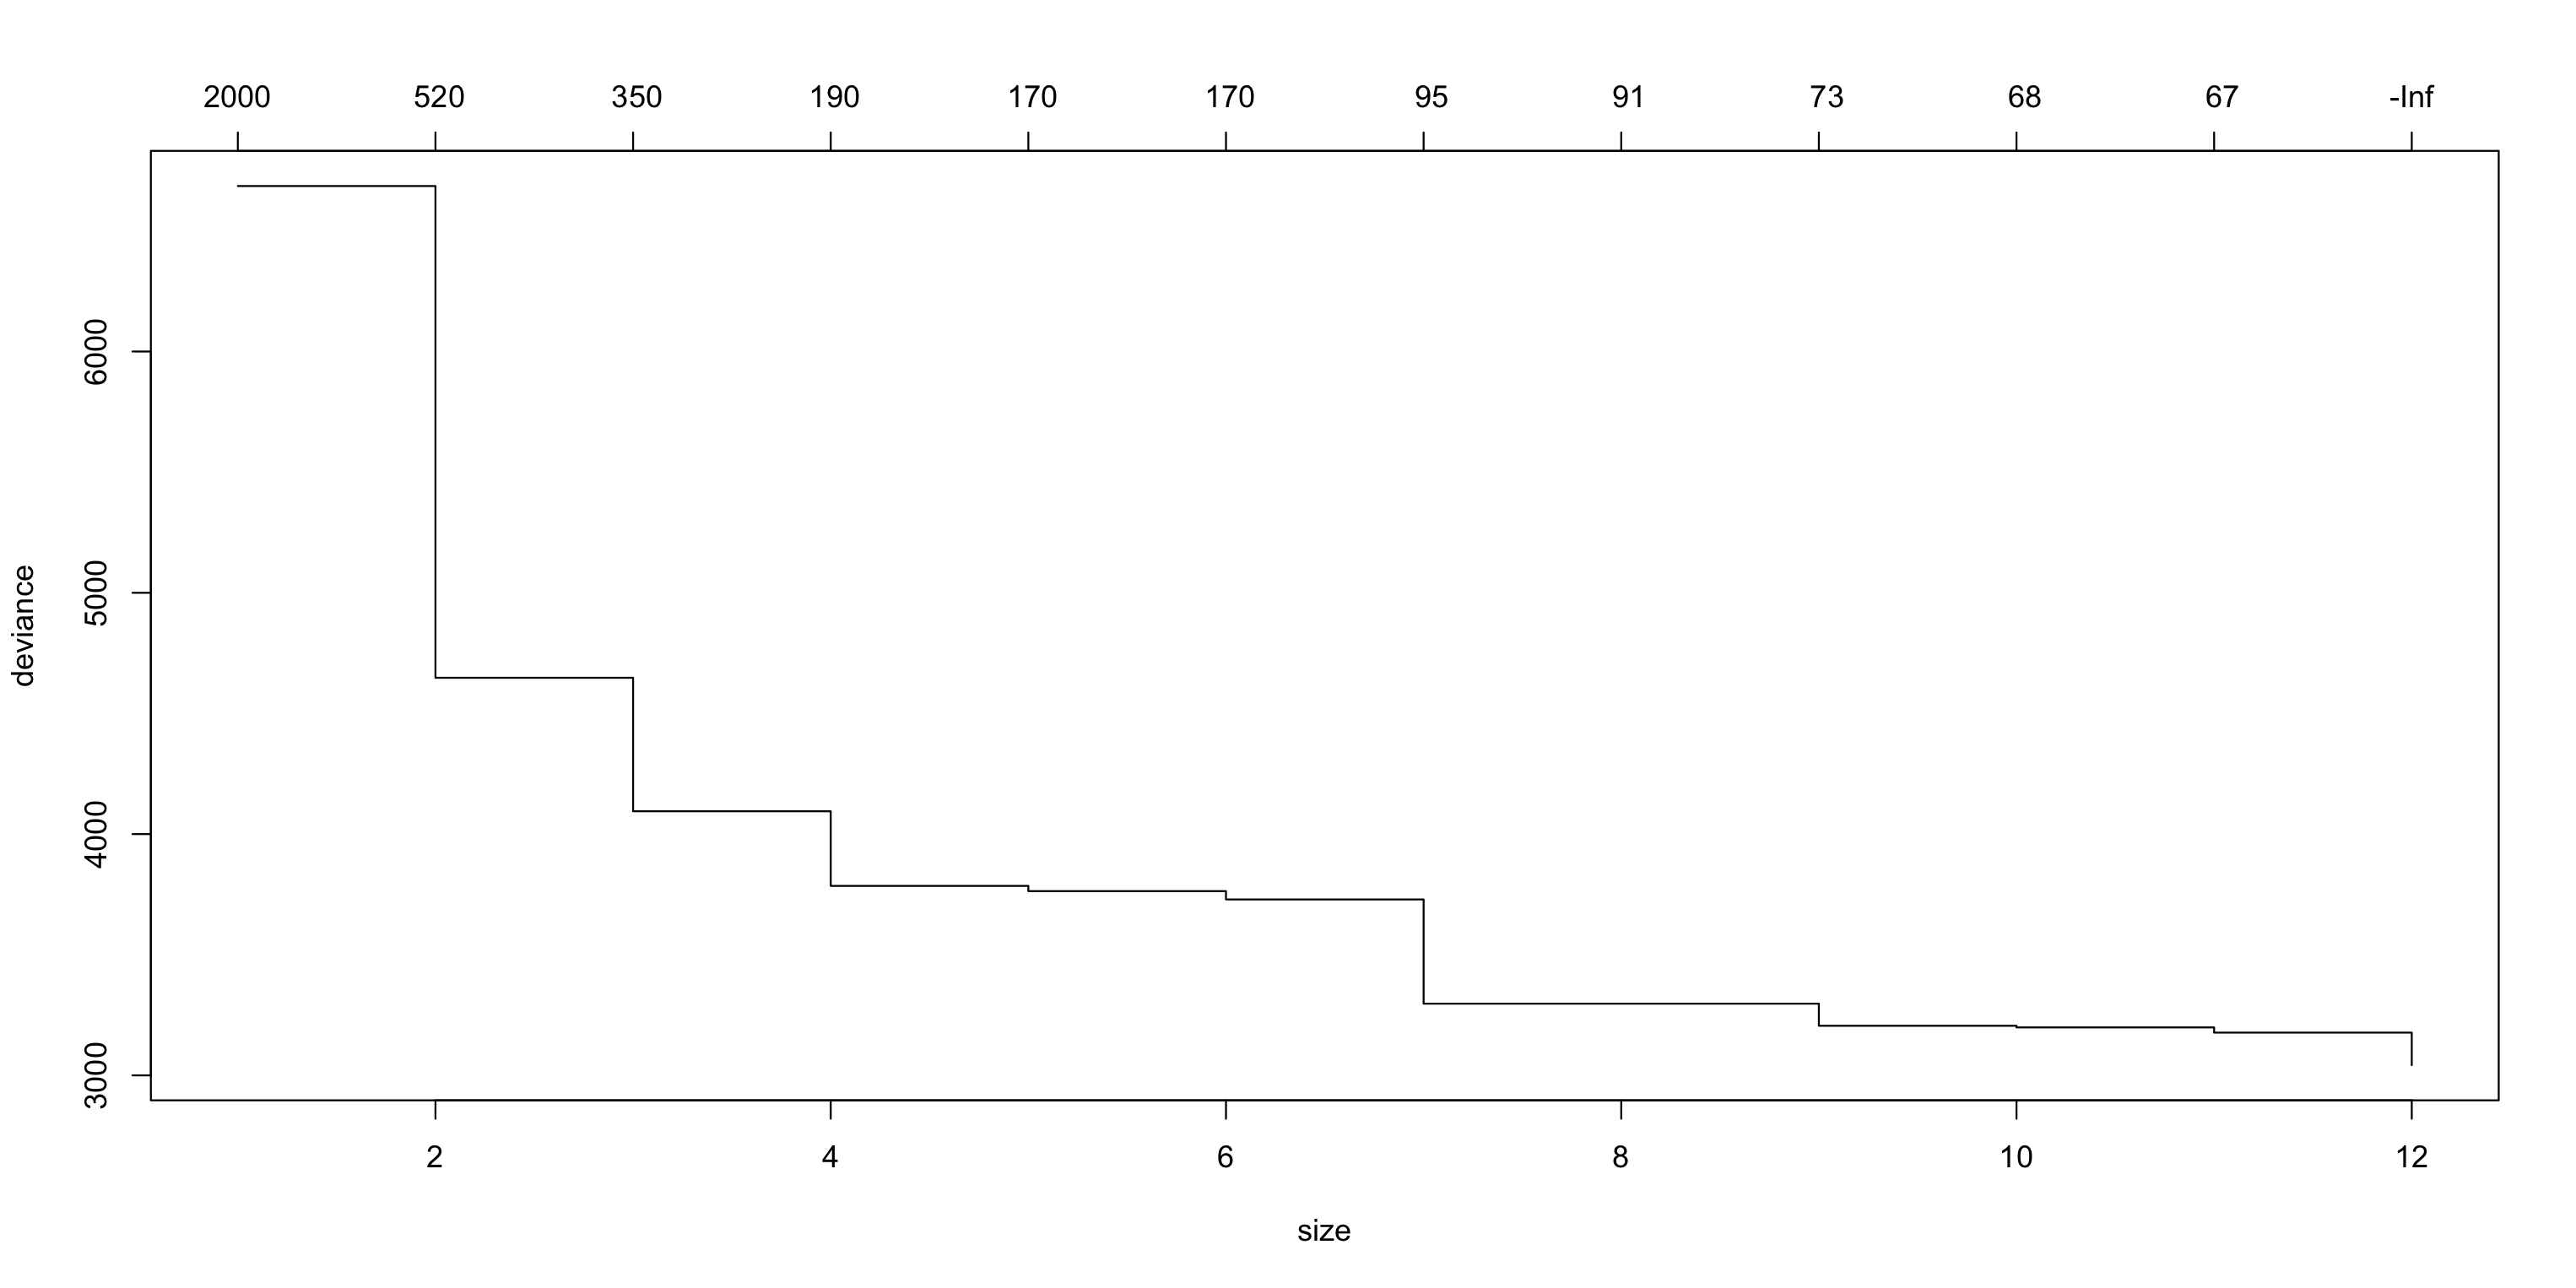

In [31]:
cvca <- cv.tree(catree)
cvca$size[which.min(cvca$dev)]
plot(cvca)

Here comes bagging (bootstrap aggregation) of trees into a random forest.

It takes some time to run, you can limit the number of trees and the minimum tree size for speed.
We add some `importance` so that we store the variable importance information, FWIW.

In [32]:
carf <- ranger(logMedVal ~ ., data=CAhousing, 
  write.forest=TRUE, num.tree=200, min.node.size=25, importance="impurity")

Have a look at the variable importance:

In [33]:
sort(carf$variable.importance, decreasing=TRUE)

medianIncome         latitude        longitude     AveOccupancy 
       2326.4203         991.0682         929.0617         608.5841 
        AveRooms housingMedianAge        AveBedrms       households 
        594.6571         214.4985         162.4123         122.3546 
      population 
        104.9366

## Prediction and plotting fit

In [34]:
yhatlasso <- predict(calasso, XXca, lmr=1e-4)
yhattree <- predict(catree, CAhousing)
yhatrf <- predict(carf, CAhousing)$predictions

We can plot the predictions by location. This is a bit complex, only if you're interested.

We can also use color maps for fit and residuals.

In [35]:
predcol = heat.colors(9)[9:1] ## see help(heat.colors)
residcol = c('red','orange',0,'turquoise','blue')
predbreaks = c(9,10,10.5,11,11.5,12,12.5,13,13.5,14.5) # borders of pred color bins
residbreaks = c(-3,-2,-1,1,2,3) # borders of resid color bins

These functions simplify life later. Again, `R` is powerful, but can be confusing.

In [36]:
predmap <- function(y){
  return(predcol[cut(drop(y),predbreaks)]) ## cut sorts into bins
}
residmap <- function(e){
  return(residcol[cut(drop(e), residbreaks)]) ## cut sorts into bins
}

The `maps` package can add the California outline.

In [37]:
#install.packages("maps")
library(maps)

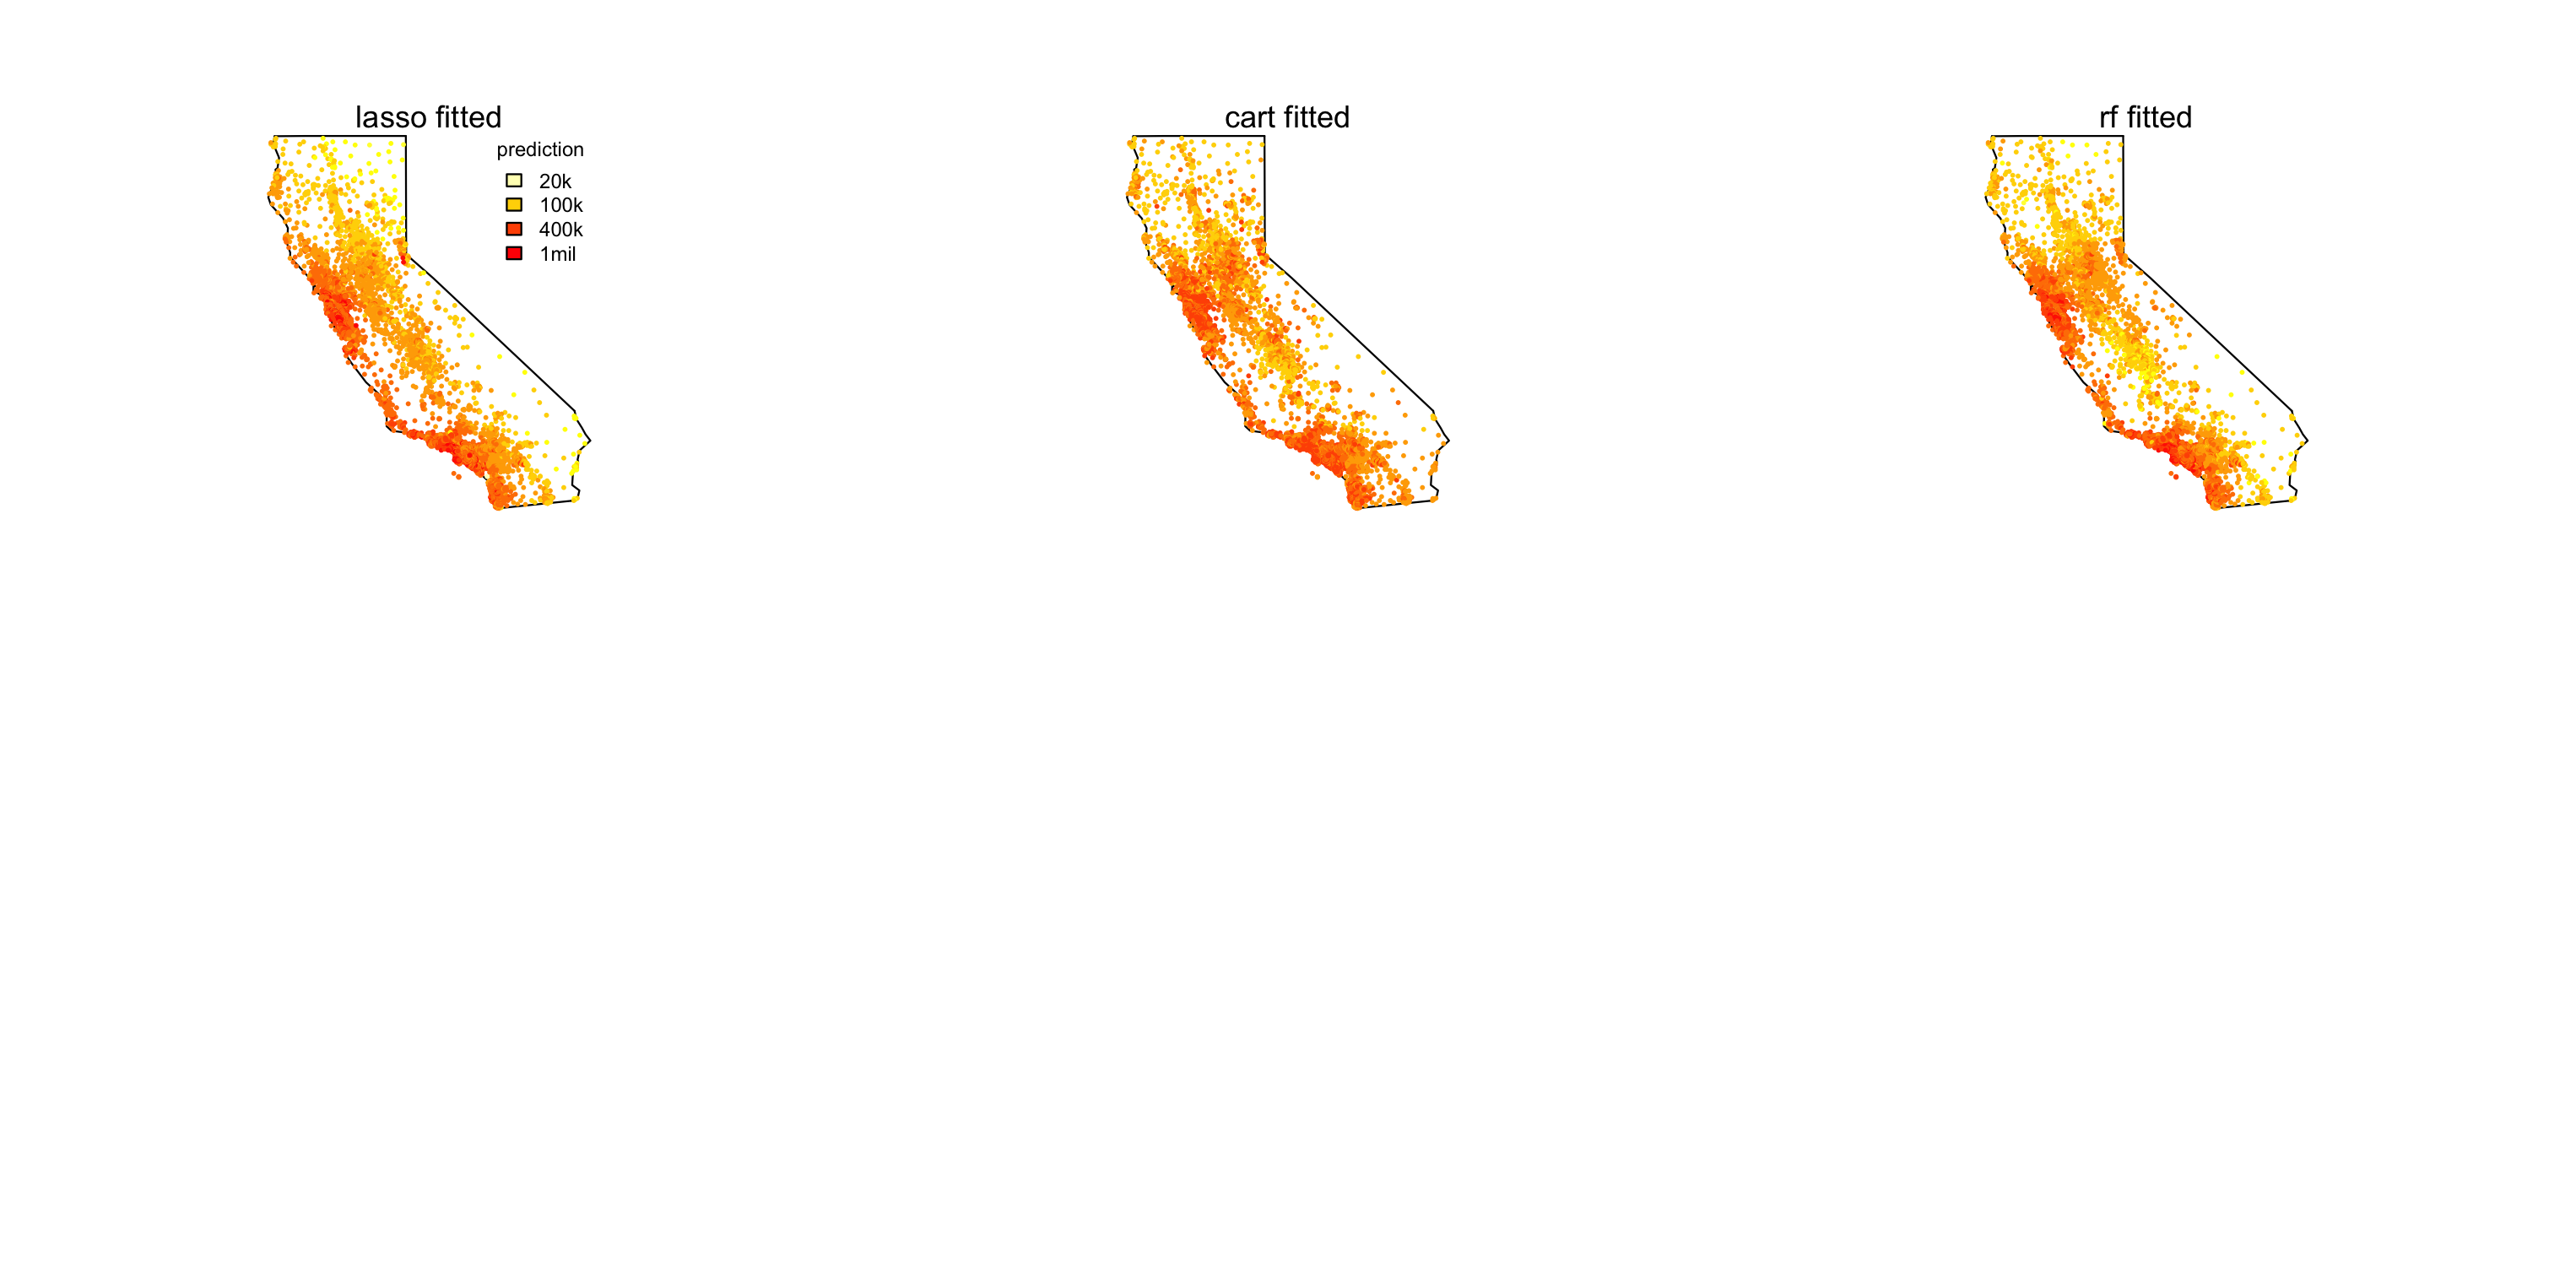

In [38]:
par(mfrow=c(2,3))
map('state', 'california') 
points(CAhousing[,1:2], col=predmap(yhatlasso), pch=20, cex=.5)
mtext("lasso fitted")
legend("topright", title="prediction", bty="n",
       fill=predcol[c(1,4,7,9)], legend=c("20k","100k","400k","1mil"))
map('state', 'california') 
points(CAhousing[,1:2], col=predmap(yhattree), pch=20, cex=.5)
mtext("cart fitted")
map('state', 'california') 
points(CAhousing[,1:2], col=predmap(yhatrf), pch=20, cex=.5)
mtext("rf fitted")

We can repeat the same thing for the residuals.

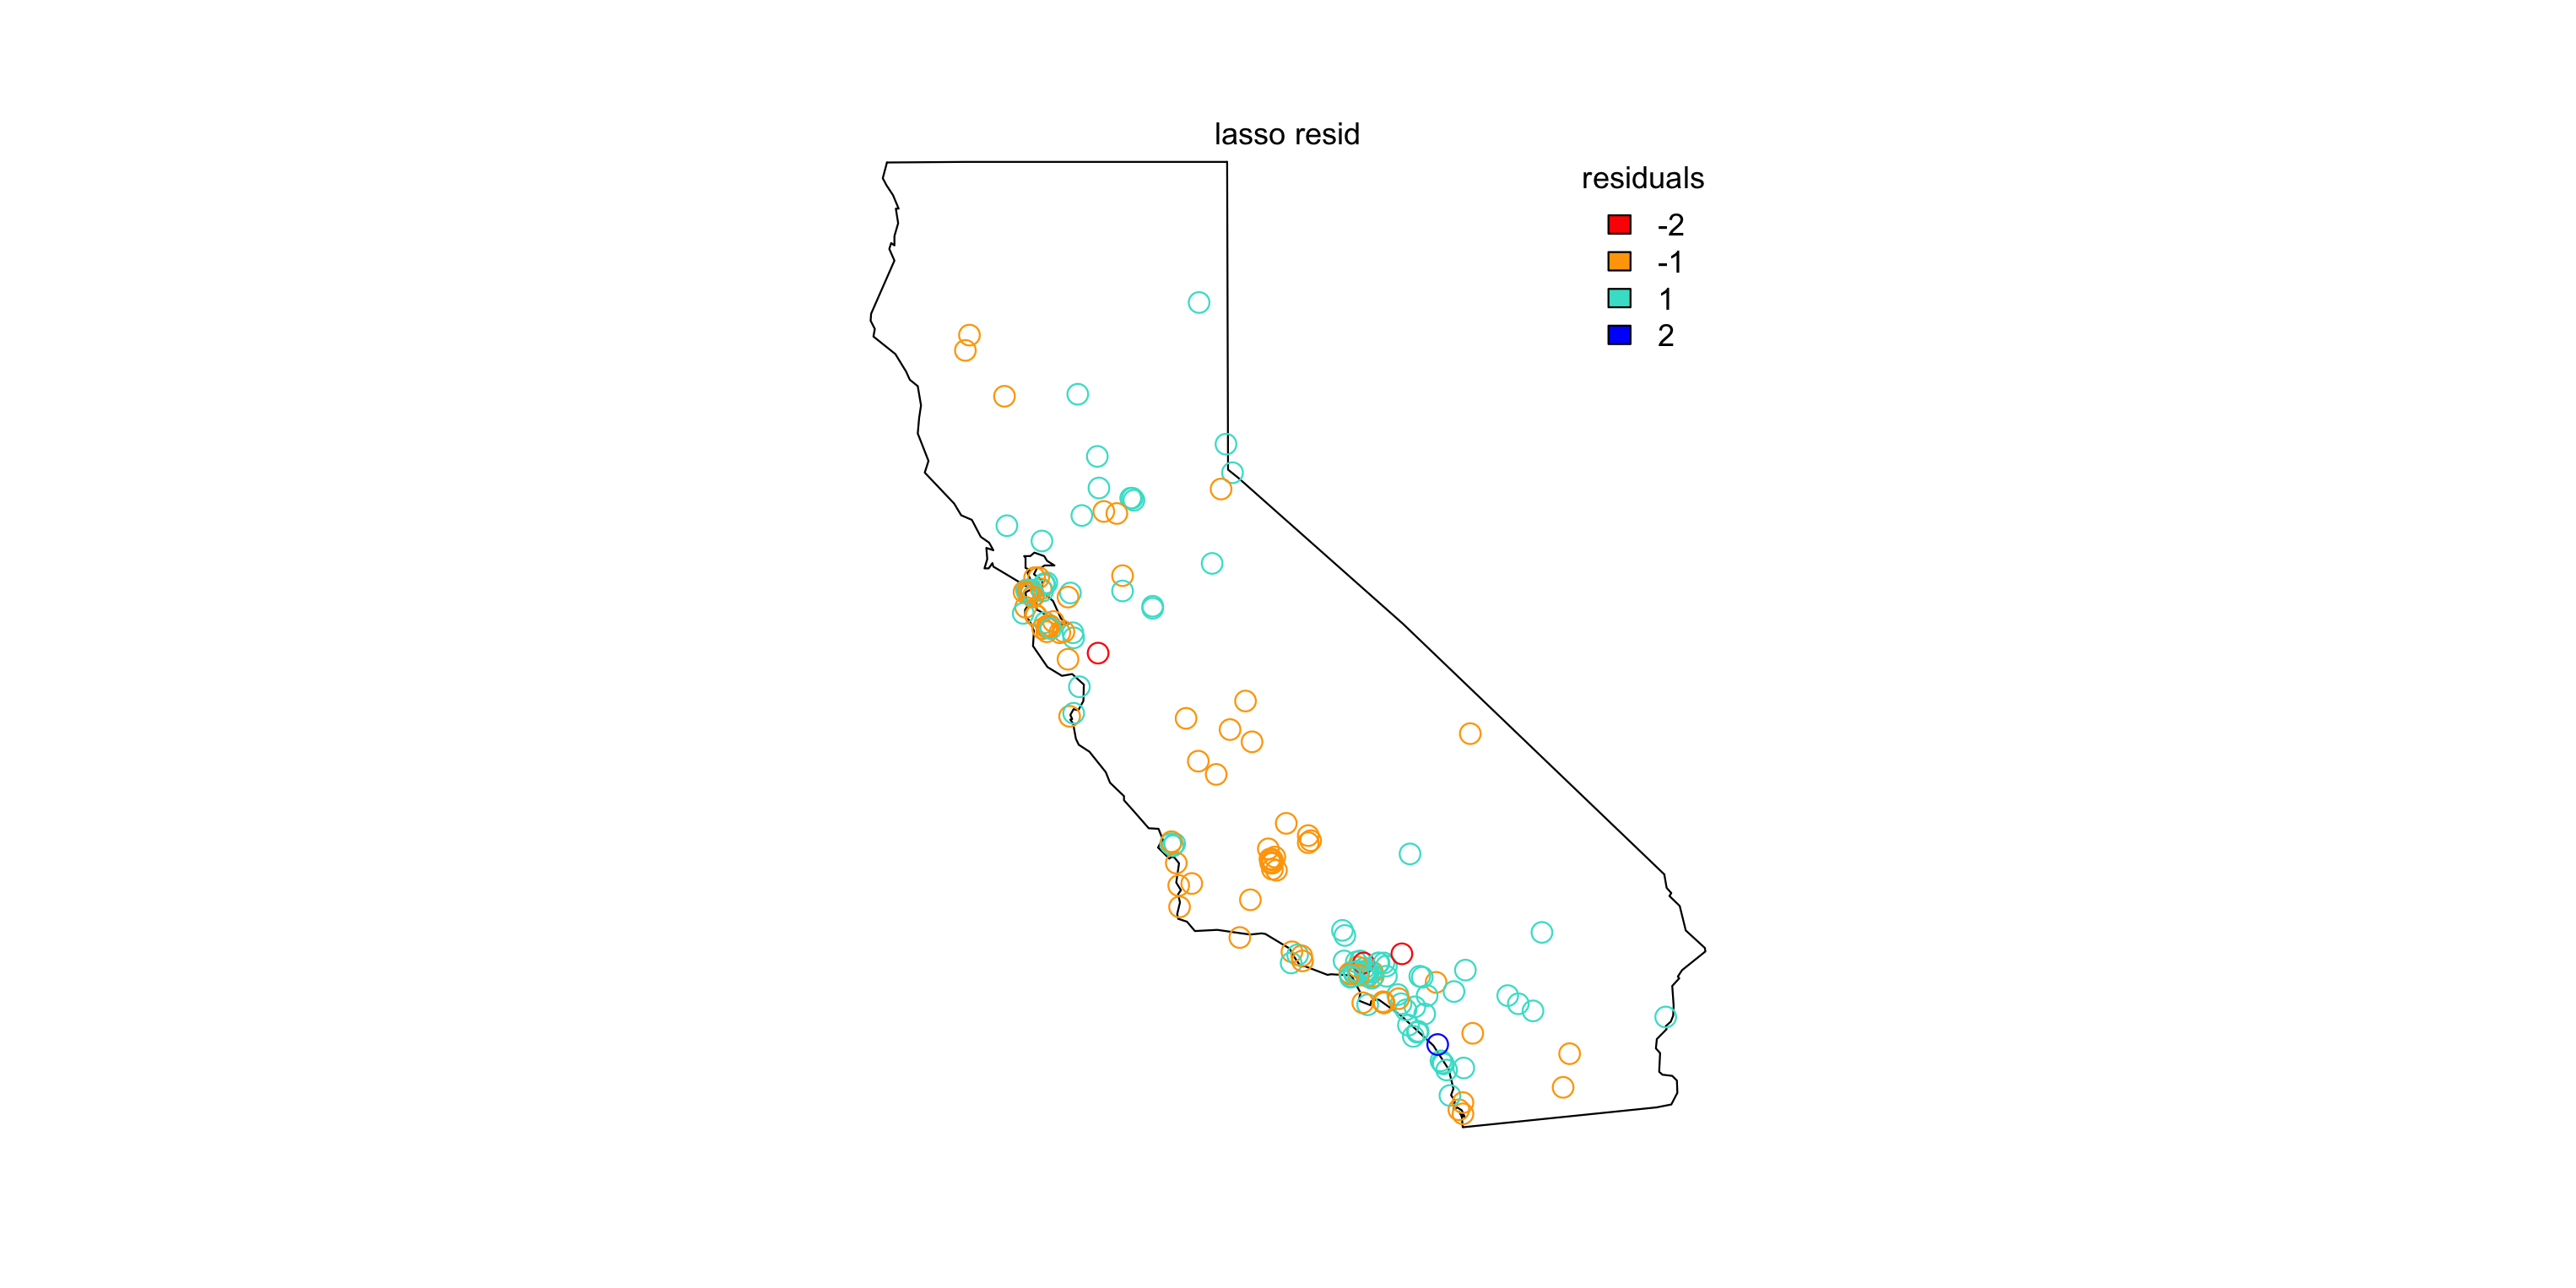

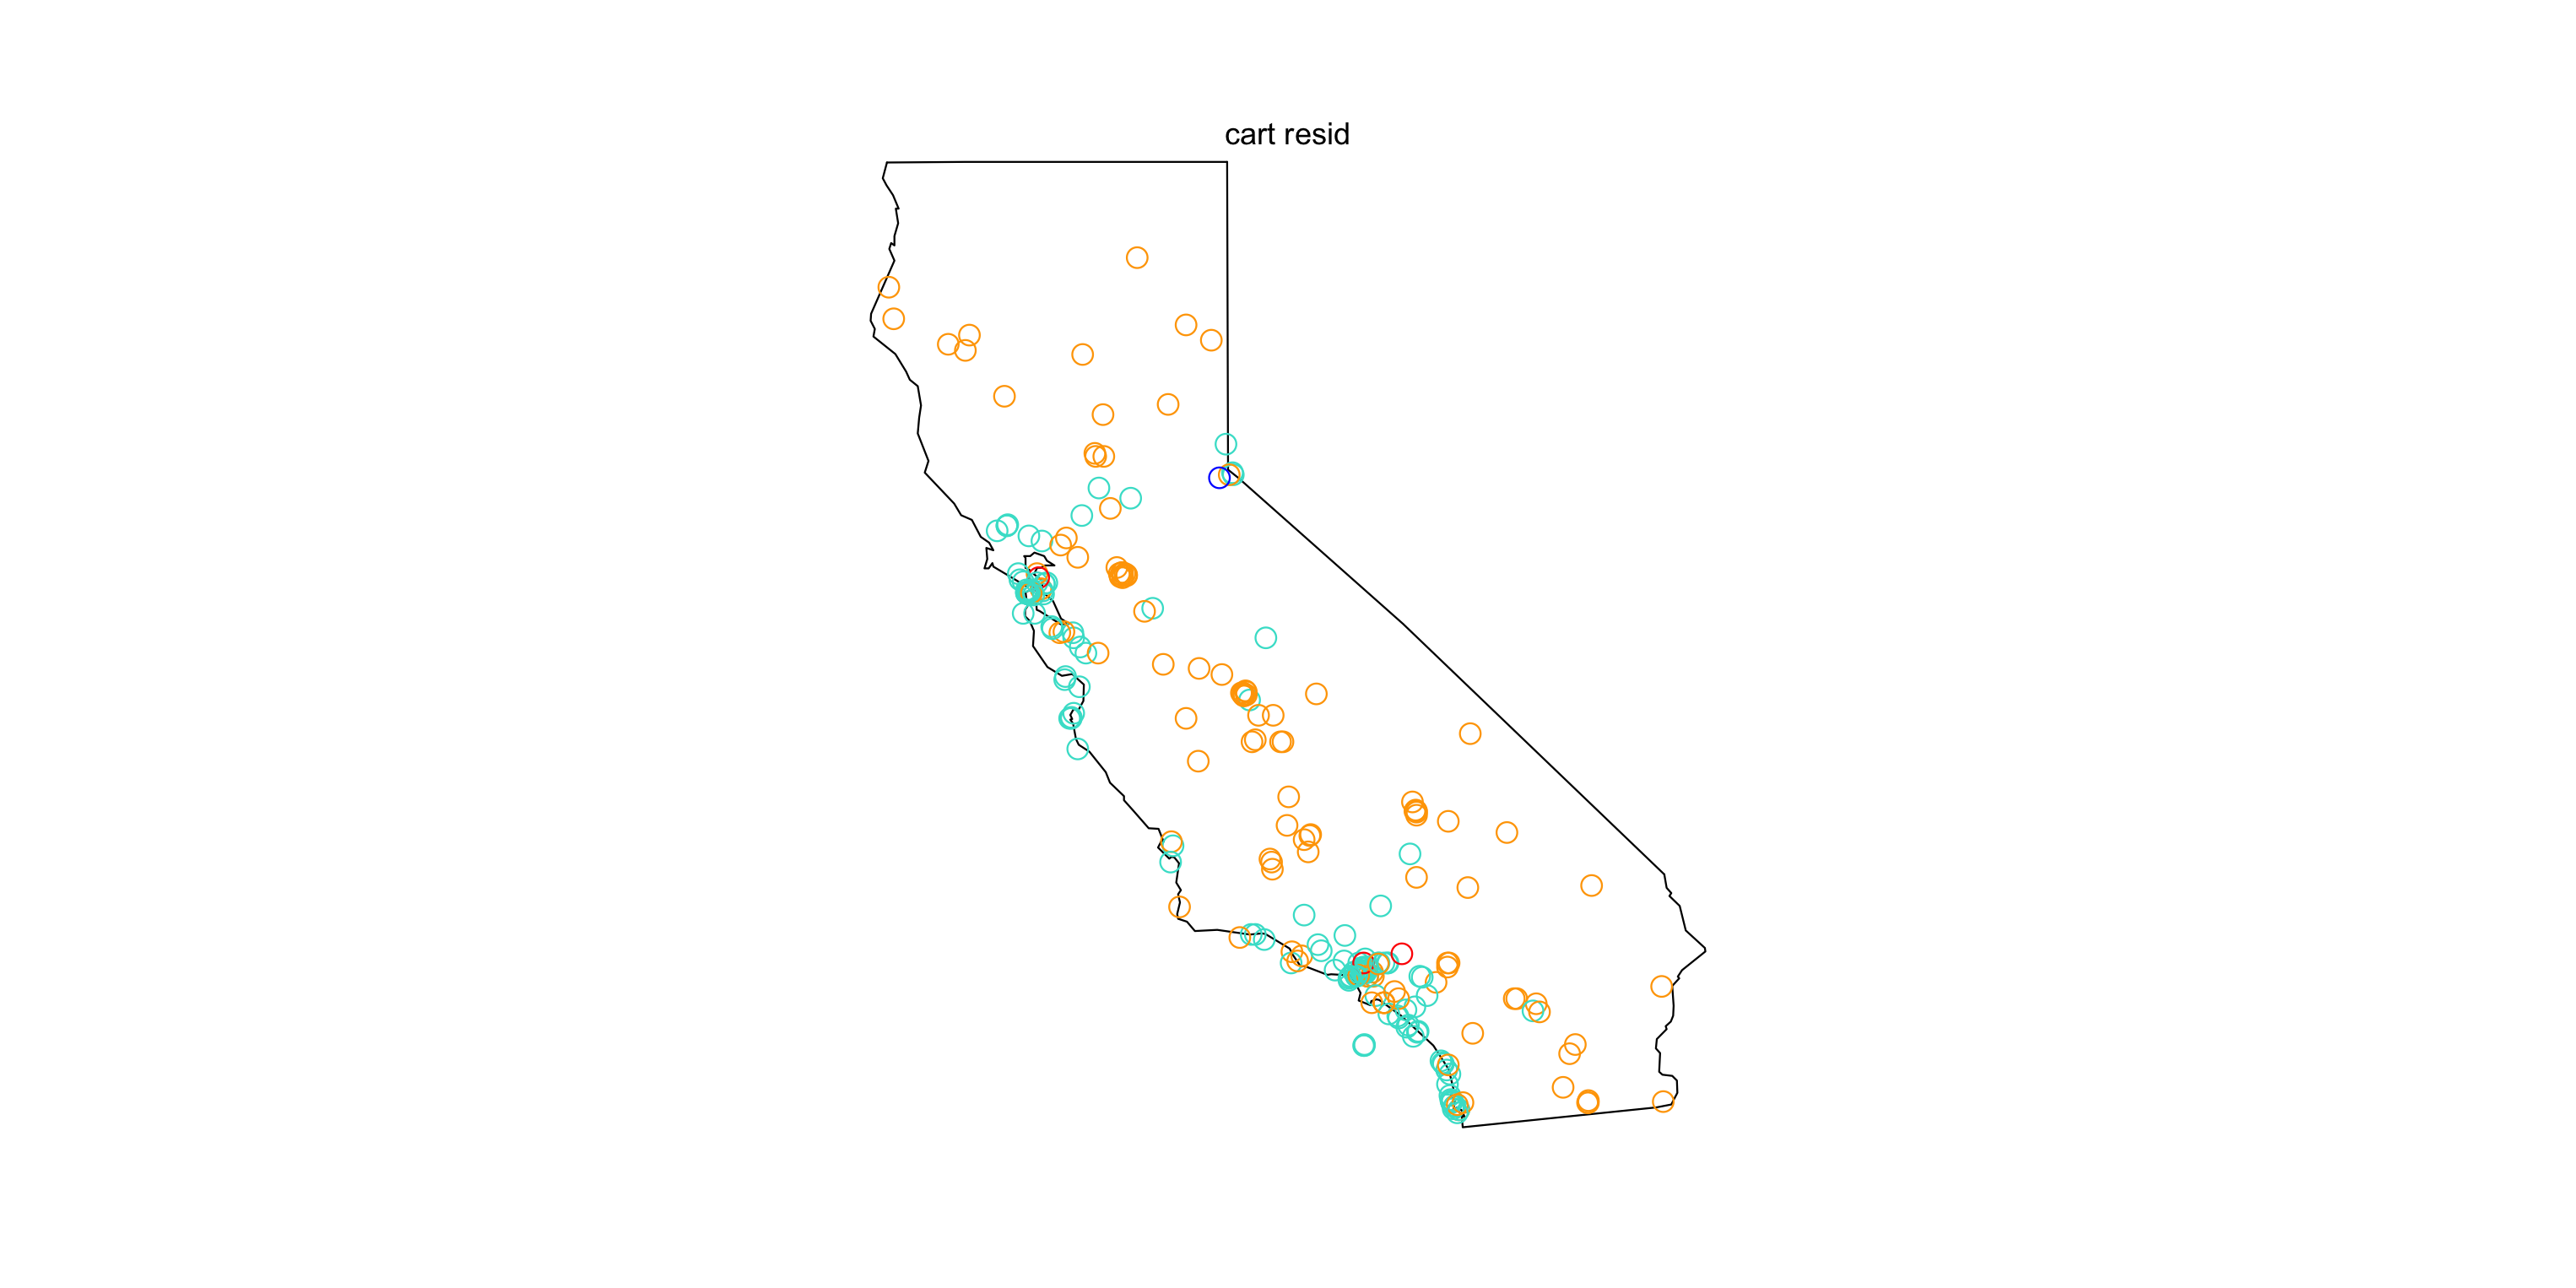

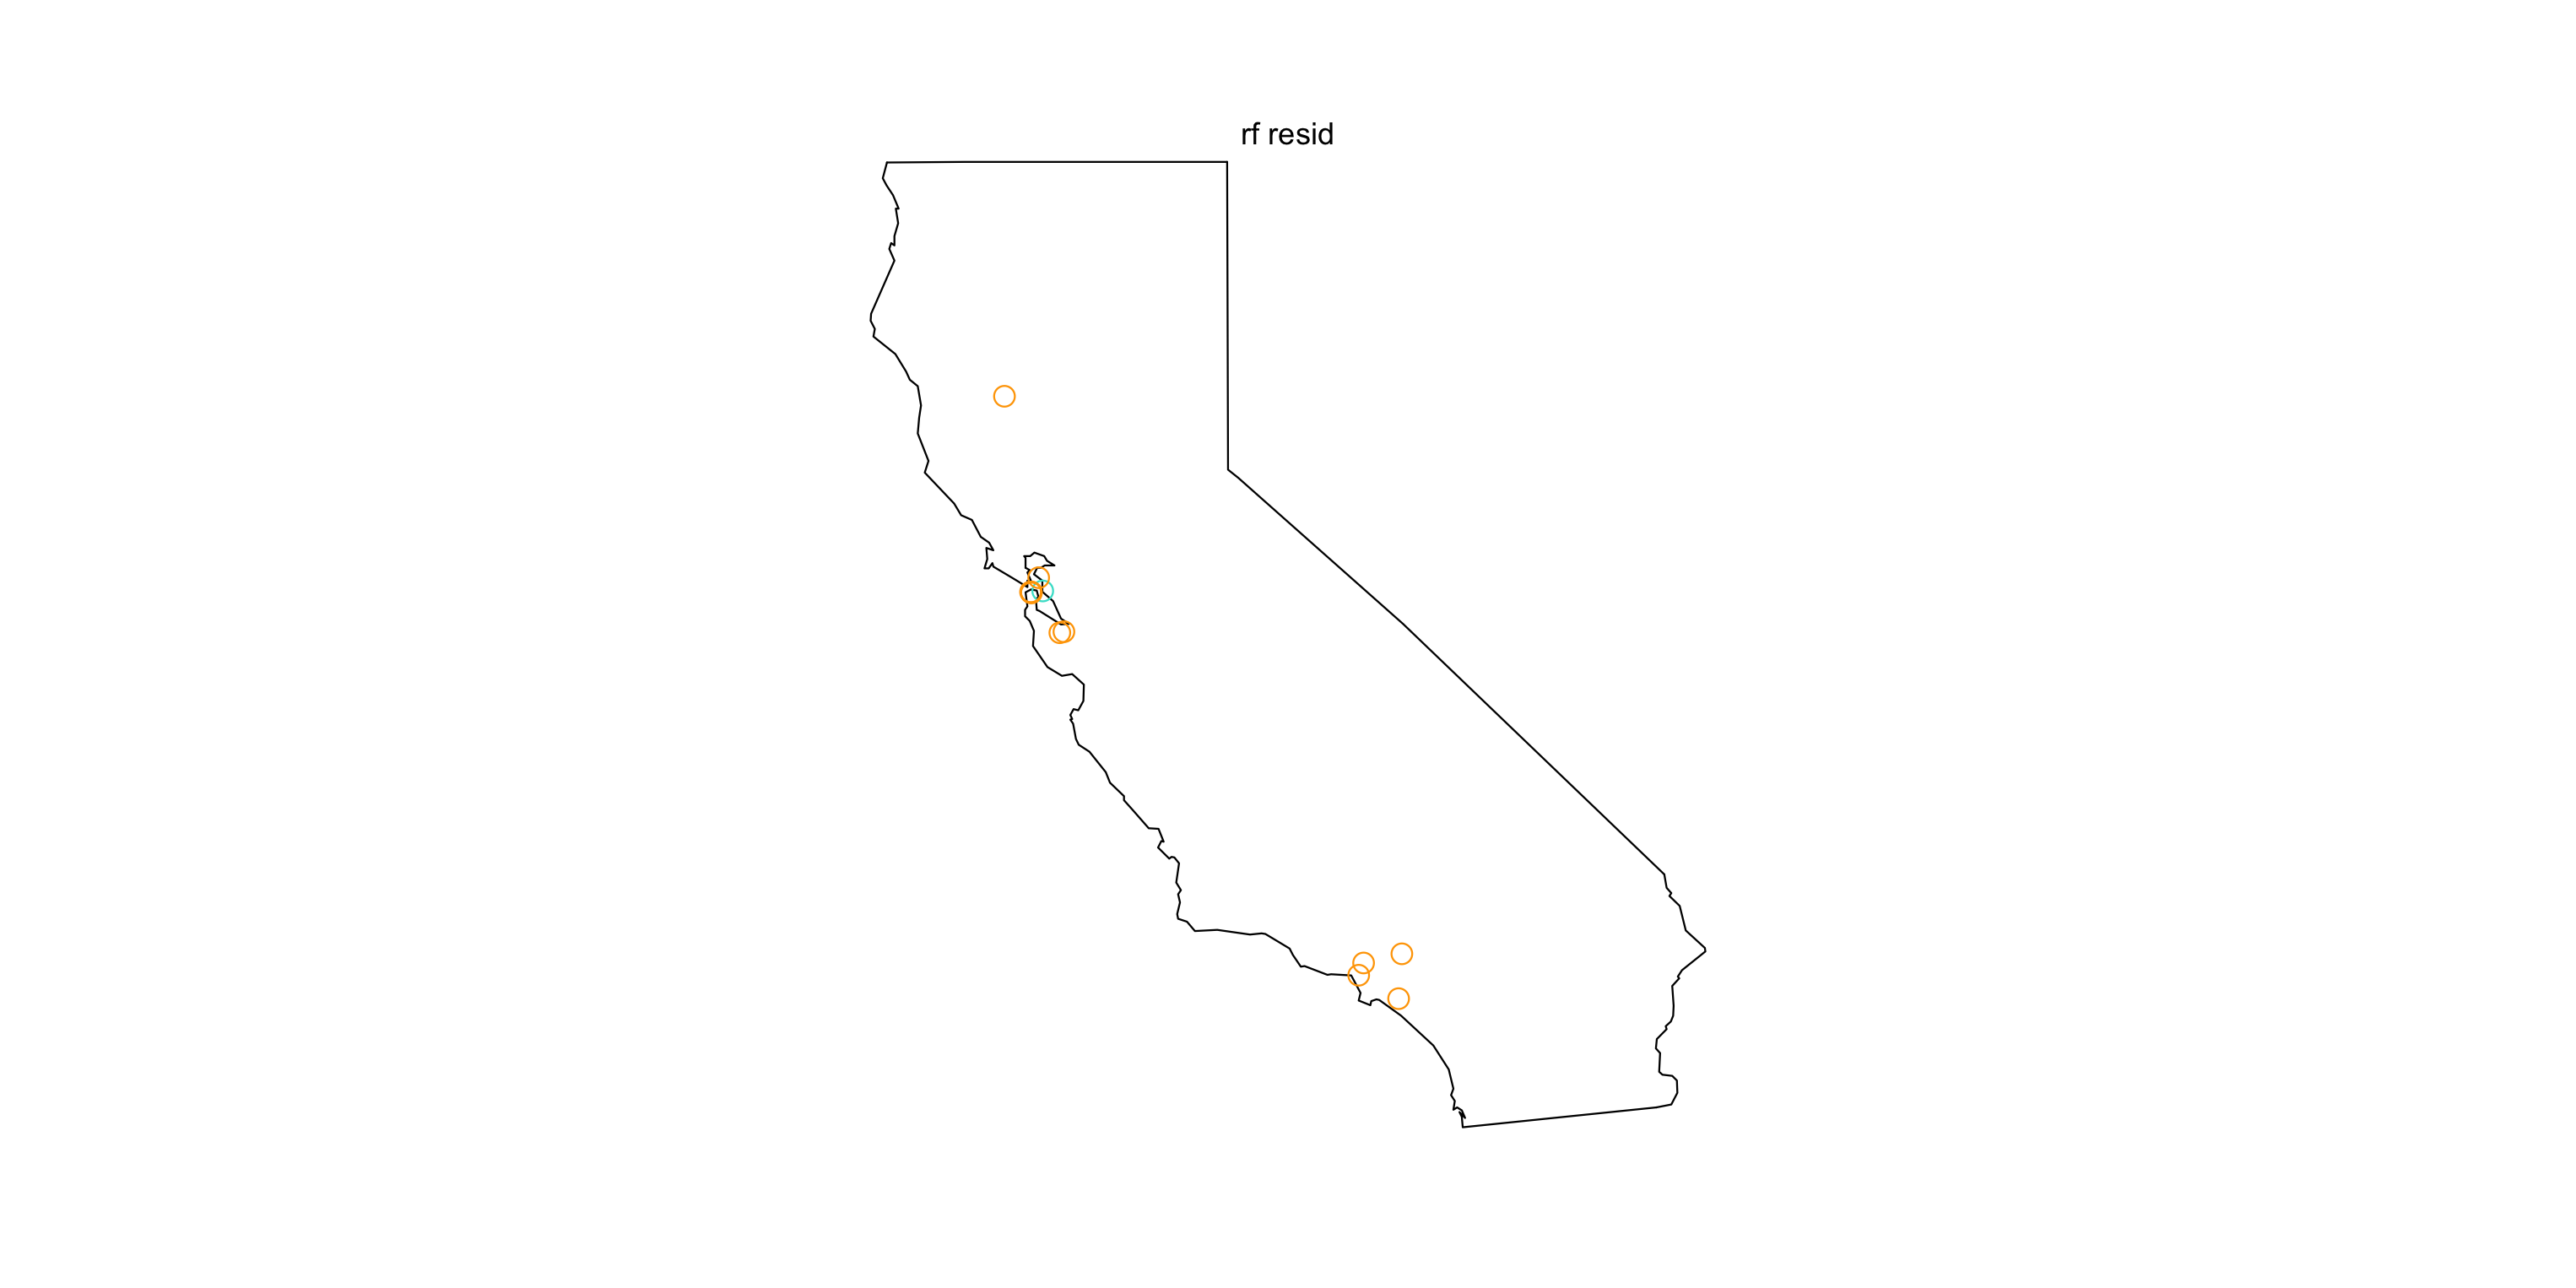

In [39]:
map('state', 'california') 
points(CAhousing[,1:2], col=residmap(logMedVal - yhatlasso), cex=1.5)
mtext("lasso resid")
legend("topright", title="residuals", bty="n", fill=residcol[-3], legend=c(-2,-1, 1,2))
map('state', 'california') 
points(CAhousing[,1:2], col=residmap(logMedVal - yhattree), cex=1.5)
mtext("cart resid")
map('state', 'california') 
points(CAhousing[,1:2], col=residmap(logMedVal - yhatrf), cex=1.5)
mtext("rf resid")

Out of sample prediction can take a while since RF is slow.

12345678910

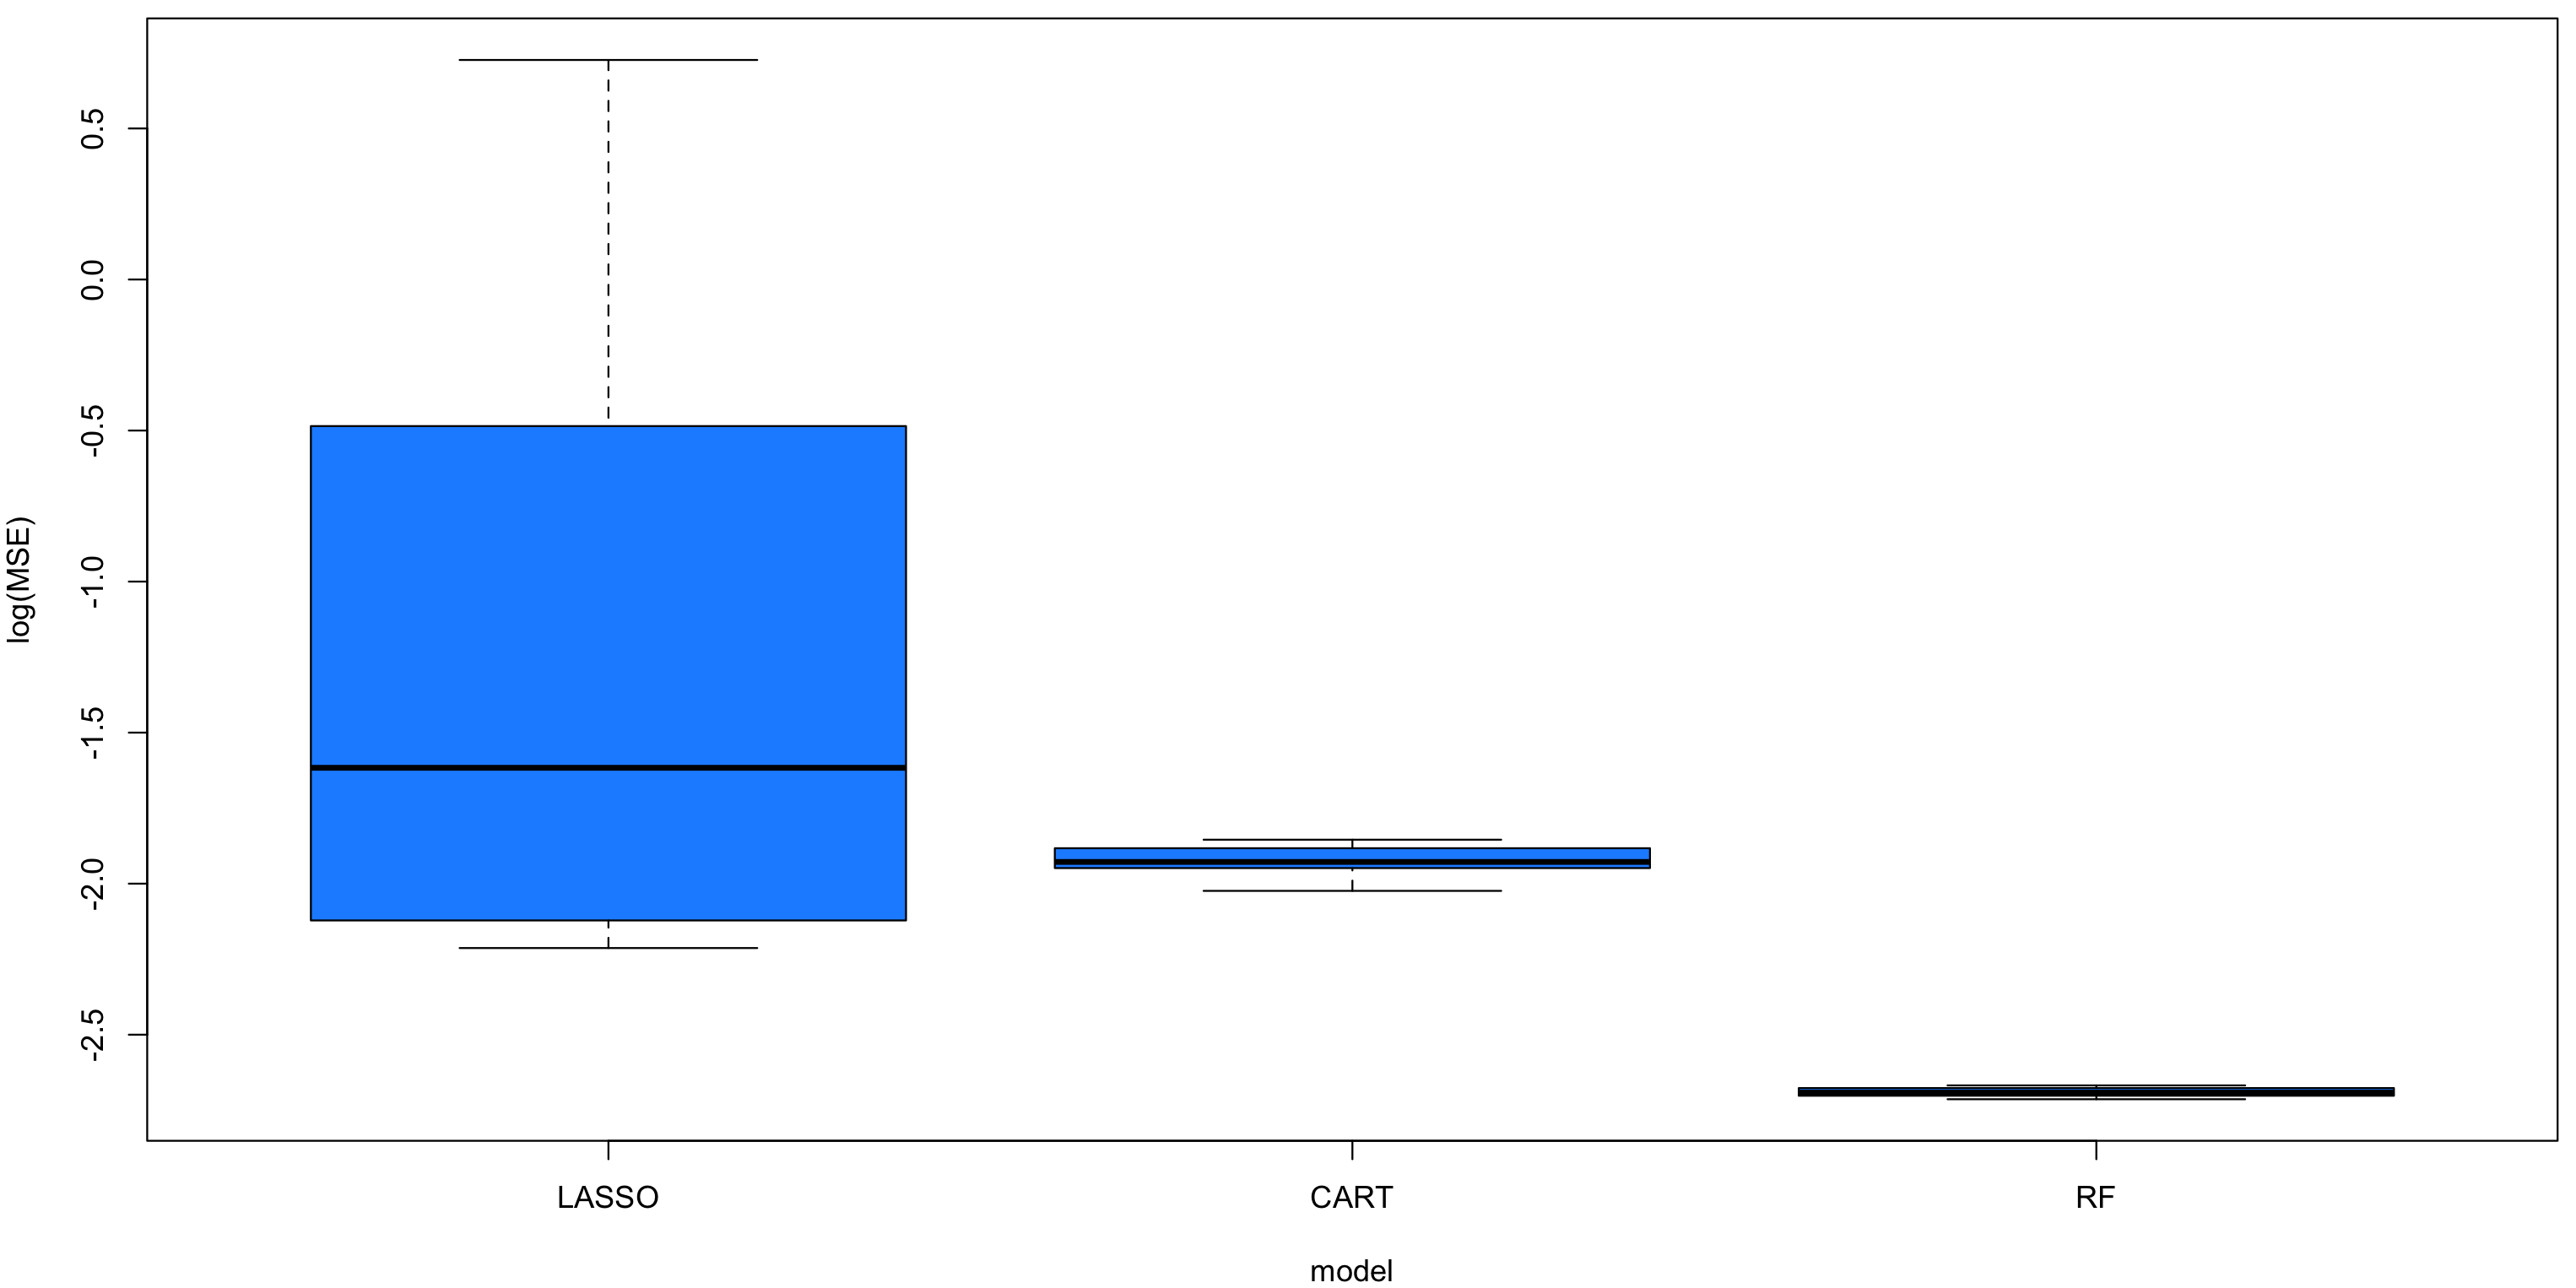

In [40]:
MSE <- list(LASSO=NULL, CART=NULL, RF=NULL)
for(i in 1:10){
  train <- sample(1:nrow(CAhousing), 5000)
  
  lin <- cv.gamlr(x=XXca[train,], y=logMedVal[train], lmr=1e-4)
  yhat.lin <- drop(predict(lin, XXca[-train,]))
  MSE$LASSO <- c( MSE$LASSO, var(logMedVal[-train] - yhat.lin))

  rt <- tree(logMedVal[train] ~ ., data=CAhousing[train,])
  yhat.rt <- predict(rt, newdata=CAhousing[-train,])
  MSE$CART <- c( MSE$CART, var(logMedVal[-train] - yhat.rt))

  rf <- ranger(logMedVal[train] ~ ., data=CAhousing[train,], 
          num.tree=200, min.node.size=25, write.forest=TRUE)
  yhat.rf <- predict(rf, data=CAhousing[-train,])$predictions
  MSE$RF <- c( MSE$RF, var(logMedVal[-train] - yhat.rf) )
 
  cat(i)
} 
par(mai=c(.8,.8,.1,.1))
boxplot(log(as.data.frame(MSE)), col="dodgerblue", xlab="model", ylab="log(MSE)")

You can try parallel processing:

In [41]:
library(parallel)
cl <- makeCluster(4) # use 4 processors
clusterExport(cl, c("randomForest","logMedVal","CAhousing")) # broadcast the data 
out <- parLapply(cl, rep(50,4), 
  function(ntree) randomForest(logMedVal ~ ., data=CAhousing, ntree=ntree))

In [42]:
system.time(carf <- ranger(logMedVal ~.,data = CAhousing,num.threads = 1,write.forest = TRUE, num.tree=200,min.node.size = 25,importance="impurity"))
system.time(carf <- ranger(logMedVal ~.,data = CAhousing,num.threads = NULL,write.forest = TRUE, num.tree=200,min.node.size = 25,importance="impurity"))

   user  system elapsed 
  8.168   0.085  14.806 

   user  system elapsed 
  7.452   0.058   5.690 

# More heterogenous treatment effects of the Oregon Health Insurance Experiment

This uses such cool packages, that we need a new package just to install some cutting-edge packages straight from Github.

In [43]:
#install.packages("devtools")
#library(devtools) 
#install_github("susanathey/causalTree")

As before, we need to wrangle the data to get started:

In [44]:
library(foreign)
descr <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_descriptive_vars.dta")
prgm <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_stateprograms_vars.dta")
s12 <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_survey12m_vars.dta")
all(s12$person_id == descr$person_id)
all(s12$person_id == prgm$person_id)
P <- descr[,c("person_id","household_id", "numhh_list")]
P$medicaid <- as.numeric(prgm[,"ohp_all_ever_firstn_30sep2009"]=="Enrolled")
P$selected <- as.numeric(descr[,"treatment"]=="Selected")
levels(P$numhh_list) <- c("1","2","3+")
Y <- s12[,c("weight_12m",
	"doc_any_12m","doc_num_mod_12m",
	"er_any_12m","er_num_mod_12m",
	"hosp_any_12m","hosp_num_mod_12m")]
Y$doc_any_12m <- as.numeric(Y$doc_any_12m=="Yes")
Y$er_any_12m <- as.numeric(Y$er_any_12m=="Yes")
Y$hosp_any_12m <- as.numeric(Y$hosp_any_12m=="Yes")
X <- s12[,121:147]
X$dt_returned <- factor(format(s12$dt_returned_12m, "%Y-%m"))
insurv <- which(s12$sample_12m_resp == "12m mail survey responder")
X <- X[insurv,]
Y <- Y[insurv,]
P <- P[insurv,]
sapply(Y,function(y) sum(is.na(y)))
nomiss <- which( !apply(Y,1, function(y) any(is.na(y))) )
X <- X[nomiss,]
Y <- Y[nomiss,]
P <- P[nomiss,]
weights <- Y[,1]
Y <- Y[,-1]
X$hhsize_12m[X$hhsize_12m>10] <- 10
X$num19_12m <- NULL
P$doc_any_12m <- Y$doc_any_12m
P <- P[,c(1,2,6,5,4,3)]
names(P)[6] <- "numhh"

[1] TRUE

[1] TRUE

weight_12m      doc_any_12m  doc_num_mod_12m       er_any_12m 
               0              249              300              227 
  er_num_mod_12m     hosp_any_12m hosp_num_mod_12m 
             260              168              202

In [45]:
library(causalTree)
selectfit <- glm(selected ~ numhh, data = P, family=binomial)
propensity <- predict(selectfit, type="response")

Loading required package: rpart

Loading required package: rpart.plot

Loading required package: data.table



We can also remove the hhinc_cat variable to get a nicer looking tree.

[1] 2
[1] "CT"


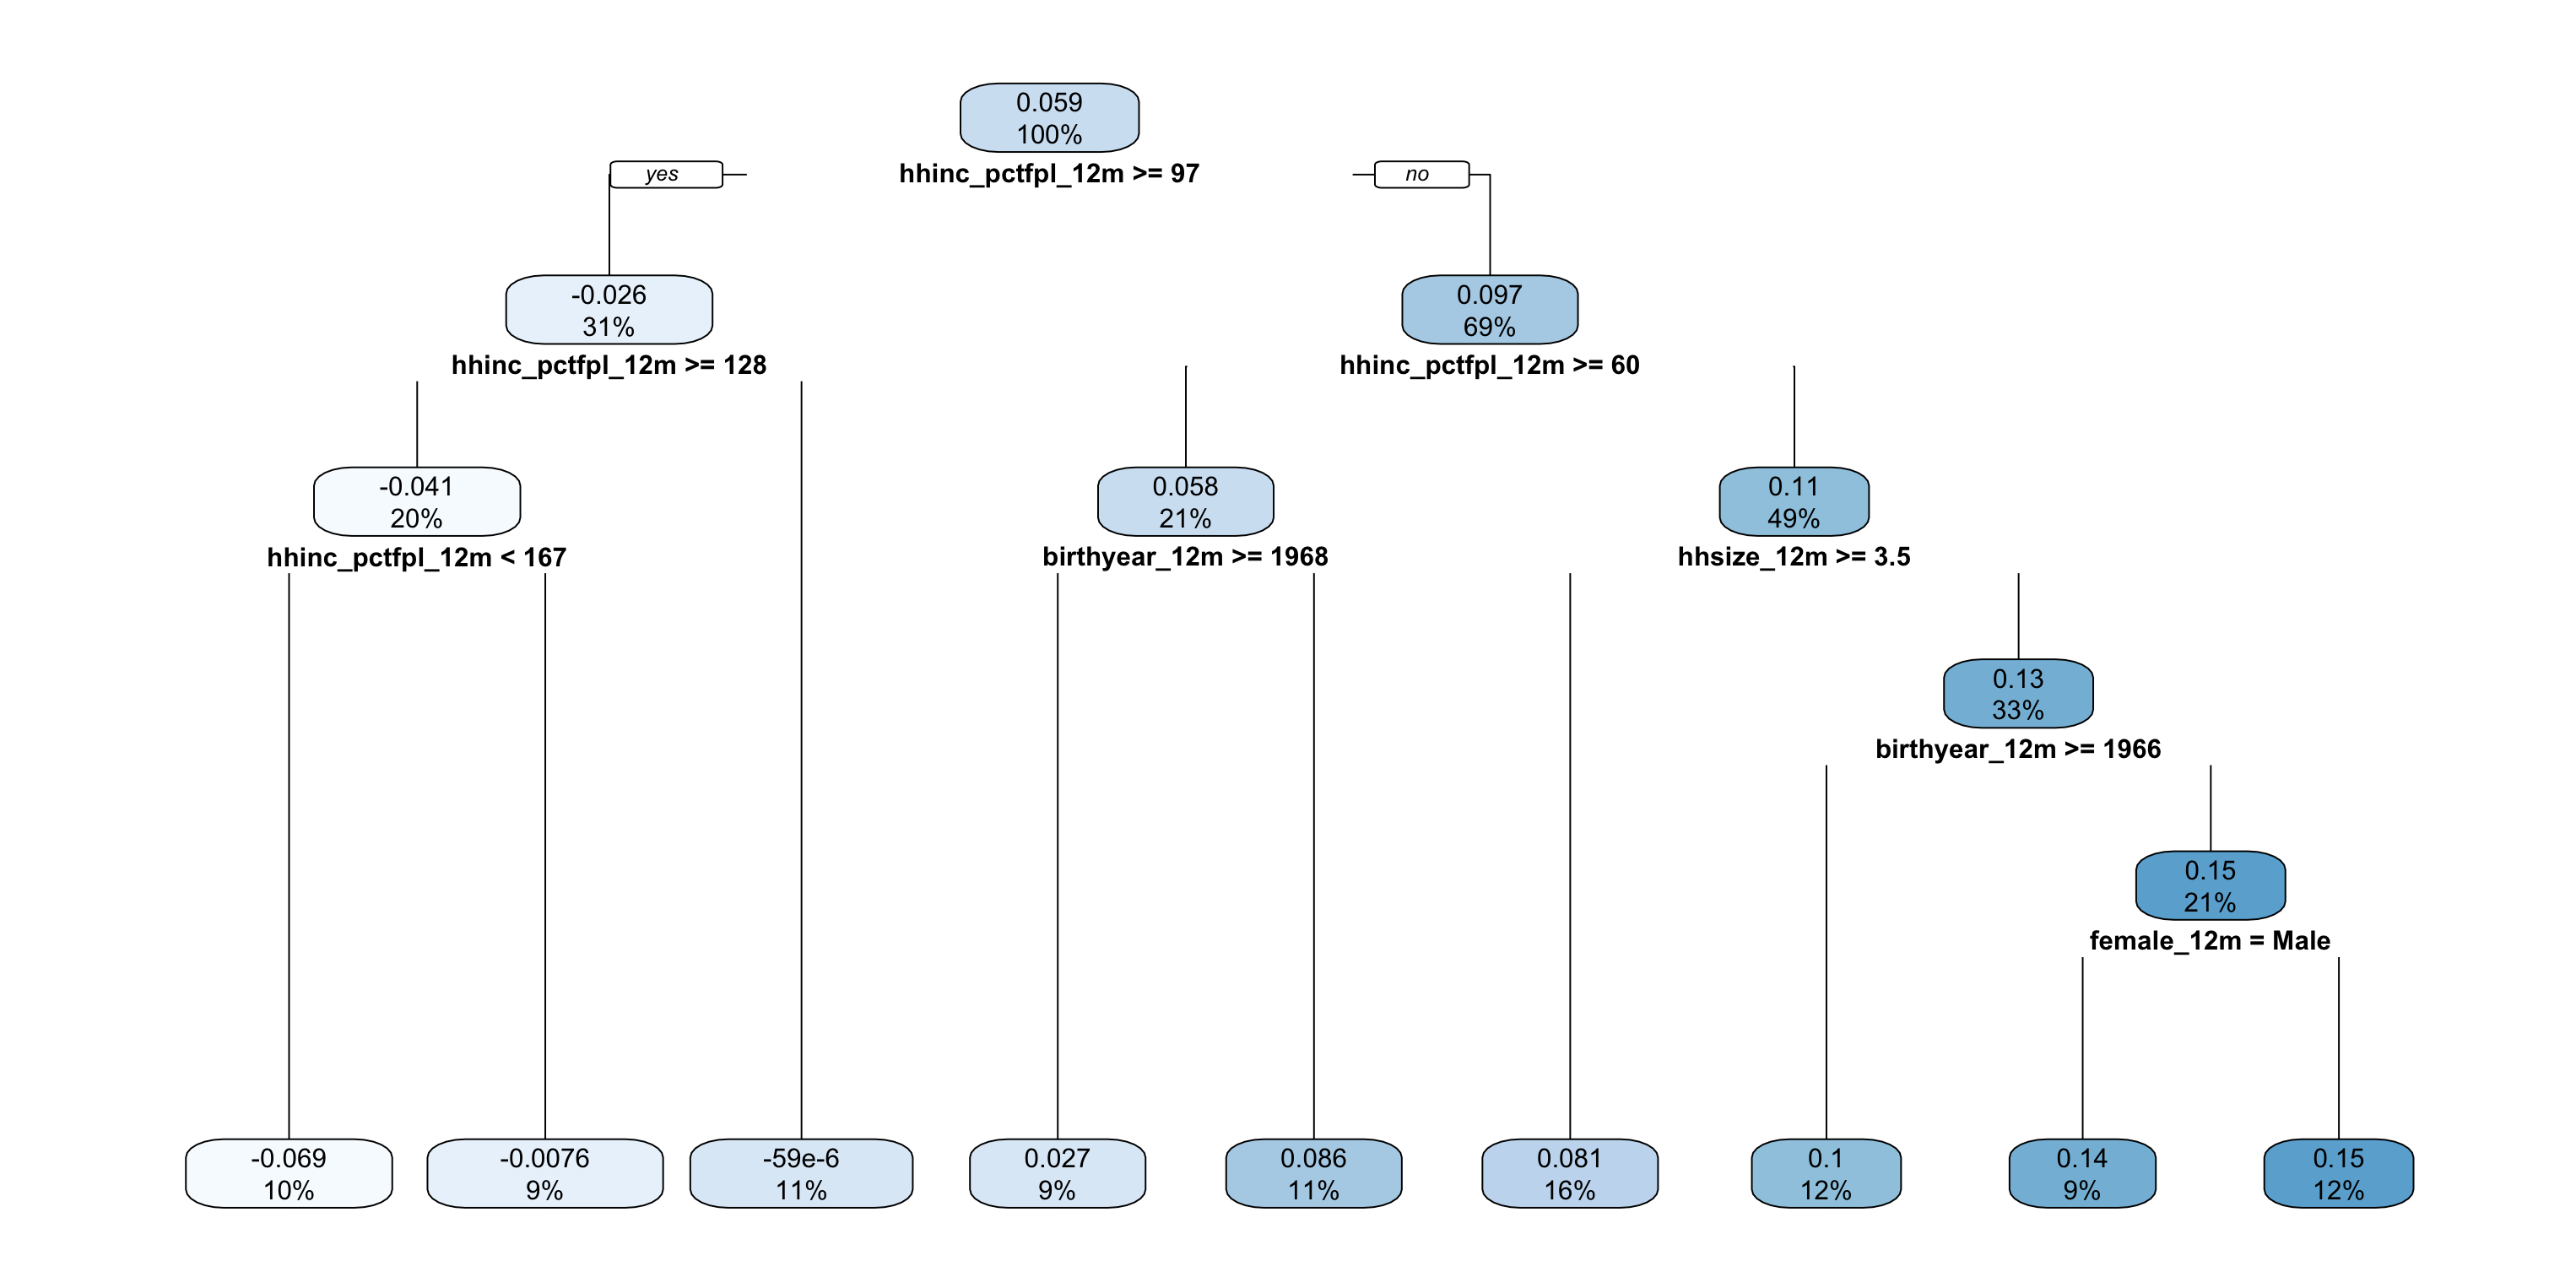

In [46]:
ct <- causalTree( P$doc_any_12m ~ .,X[,-10], 
	treatment=P$selected,  weights=1/propensity, minsize=2000,
	split.Rule = "CT", cv.option="CT", split.Honest=TRUE)
rpart.plot(ct,roundint=FALSE)

In [47]:
pdf("~/Documents/Teaching/BDS/2020/exam/CT.pdf",width=14)
rpart.plot(ct,roundint=FALSE)
dev.off()

pdf 
  2

# Gaussian Processes with whiplash

In [48]:
library(MASS)
x <- mcycle[,1,drop=FALSE]
y <- mcycle[,2]

In [49]:
#install.packages("laGP")
library(laGP)

Set parameters

In [50]:
d <- darg(NULL,x)
g <- garg(list(mle=TRUE),y)

Initialize (with `dK=TRUE`) saving what we need in estimation)

In [51]:
gpi <- newGP(x,y,d=d$start,g=g$start,dK=TRUE)

In [52]:
print(jmleGP(gpi,drange=c(d$min,d$max),grange=c(g$min,g$max)))

         d         g tot.its dits gits
1 54.92436 0.2485222      93   28   65
